<h1><center>Text Classification</center></h1>

In [1]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import stanza

#from preprocess import * 
from custom_preprocessing import CustomPreProcessing
from custom_preprocessing import PreProcessing
from class_metric import Metrics


from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils


import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

Using TensorFlow backend.
0it [00:00, ?it/s]


---

<center><h2>Parameters</h2></center>

---

This part allows you to determine the text column to classify as well as the label column.

In [2]:
TEXT = "text"
LABEL = "label"

In [3]:
# ---- Create object to preprocess the text 
preprocess = CustomPreProcessing()
preproc = PreProcessing()
Metric = Metrics()

Welcome in this custom preprocessing class
        
Welcome in the preprocessing


---

<center><h2>List of Models</h2></center>

---

In [4]:
part_of_speech         = False
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_learning          = True
pre_trained            = False
transformers_models    = False   # work in progress 
ulmfit_model           = False   # work in progress 
rbm_models             = False   # work in progress 
reinforcement_learning = False   # work in progress 

---

---

<center><i><h1>Sand Box to Load Data</h1></i></center>

---

The sandbox is the working area of your data if it has not been processed before using the pipe

In [5]:
#df = pd.read_csv("mails_clean.csv", sep=";")

In [5]:
import tensorflow_datasets as tfds

#
#
#   Test on IMDB dataset
#
#

# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'train[80%:]', 'test'),
    as_supervised=True)

In [6]:
train_x, train_y = next(iter(train_data.batch(50000)))
valid_x, valid_y = next(iter(validation_data.batch(50000)))

In [7]:
train_x.shape, valid_x.shape

(TensorShape([20000]), TensorShape([5000]))

In [8]:
df=pd.DataFrame(data=np.transpose([train_x.numpy(), train_y.numpy()]), columns=["text", "label"])
df=df.append(pd.DataFrame(data=np.transpose([train_x.numpy(), train_y.numpy()]), columns=["text", "label"]))

In [9]:
df.text = df.text.astype(str)

In [10]:
df[TEXT] = df[TEXT].progress_apply(preproc.func_remove_html)

100%|██████████| 40000/40000 [00:00<00:00, 139673.95it/s]


In [11]:
df[TEXT] = df[TEXT].progress_apply(preproc.func_remove_URL)

100%|██████████| 40000/40000 [00:01<00:00, 32376.45it/s]


In [12]:
df[TEXT] = df[TEXT].progress_apply(preproc.func_remove_numbers)

100%|██████████| 40000/40000 [00:07<00:00, 5315.68it/s]


In [33]:
df[TEXT] = df[TEXT].str.replace("'ve ", " have ")

In [85]:
df[LABEL]

0        0
1        0
2        0
3        1
4        1
        ..
19995    0
19996    1
19997    0
19998    0
19999    0
Name: label, Length: 40000, dtype: object

In [87]:
df[LABEL][df[LABEL]==0] = "negative"
df[LABEL][df[LABEL]==1] = "positive"

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


---

<center><i><h1>Sart Pipeline</h1></i></center>

---

In [ ]:
# ---- Language detection of the text
df.loc[:,"language"] = df[TEXT].progress_apply(preproc.func_detect_lang_google)

  0%|          | 85/21068 [01:07<4:40:04,  1.25it/s]

In [9]:
# ---- Extract most frequent language 
language = df.language.value_counts().index.tolist()[0]
print(f"The language most present in the dataset is {language}")

The language most present in the dataset is fr


In [13]:
language="en"

---

<h1><center>Preprocessing</center></h1>

---

The text corpora and other textual data in their native raw formats are normally not
well formatted and standardized and of course we should expect this, after all, text data
is highly unstructured! Text processing or, to be more specific preprocessing, involves a
wide variety of techniques that convert raw text into well-defined sequences of linguistic
components that have standard structure and notation. Additional metadata is often
also present in the form of annotations to give more meaning to the text components like
tags. The following list gives us an idea of some of the most popular text preprocessing
and understanding techniques.

Steps : 
- Removing HTML tags
- Tokenization
- Removing unnecessary tokens and stopwords
- Handling contractions
- Correcting spelling errors
- Stemming
- Lemmatization
- Tagging
- Chunking
- Parsing

> [Chapter 3 processing and understanding Text p.116 - Text Analytics with Python, Dipanjan Sarkar, 2019](https://www.apress.com/gp/book/9781484243534)

Tomas Mikolov is one of the developers of word2vec, a popular word embedding method. He suggests only very minimal text cleaning is required when learning a word embedding model.
Below is his response when pressed with the question about how to best prepare text data for word2vec.

><i>There is no universal answer. It all depends on what you plan to use the vectors for. In my experience, it is usually good to disconnect (or remove) punctuation from words, and sometimes also convert all characters to lowercase. One can also replace all numbers (possibly greater than some constant) with some single token such as .
>
>All these pre-processing steps aim to reduce the vocabulary size without removing any important content (which in some cases may not be true when you lowercase certain words, ie. ‘Bush’ is different than ‘bush’, while ‘Another’ has usually the same sense as ‘another’). The smaller the vocabulary is, the lower is the memory complexity, and the more robustly are the parameters for the words estimated. You also have to pre-process the test data in the same way.</i>
>
>…
>
><i>In short, you will understand all this much better if you will run experiments.</i>

> [How to Clean Text for Machine Learning with Python, Jason Brownlee](https://machinelearningmastery.com/clean-text-machine-learning-python/)

---

---

<h3>Polarity</h3>

---

In [ ]:
# ---- Polarity estimation with TextBlob
df['polarity'] = df[TEXT].map(lambda text: TextBlob(text).sentiment.polarity)

In [ ]:
# ---- Show the polarities repartition
df['polarity'].hist()

In [17]:
extract=False
if extract:
    # ---- If text aren't correctly classed 
    serie = df[LABEL][df[LABEL]!="annulation"][df[TEXT][df[LABEL]!="annulation"].apply(lambda x: preprocess.func_find_corres(x.lower(),["annulation", "annuler", "annulé"]))]
    df[LABEL][df.index.isin(serie.index)] = "annulation"

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


---

<center><h3>Text Informations</h3></center>

---

In [14]:
# ---- Extract statistics of the text 
df['char_count'] = df[TEXT].apply(len) # Number of characters in the string
df['word_count'] = df[TEXT].apply(lambda x: len(x.split())) # Number of words in the string 
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
#df['punctuation_count'] = df[TEXT].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
#df['upper_case_word_count'] = df[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

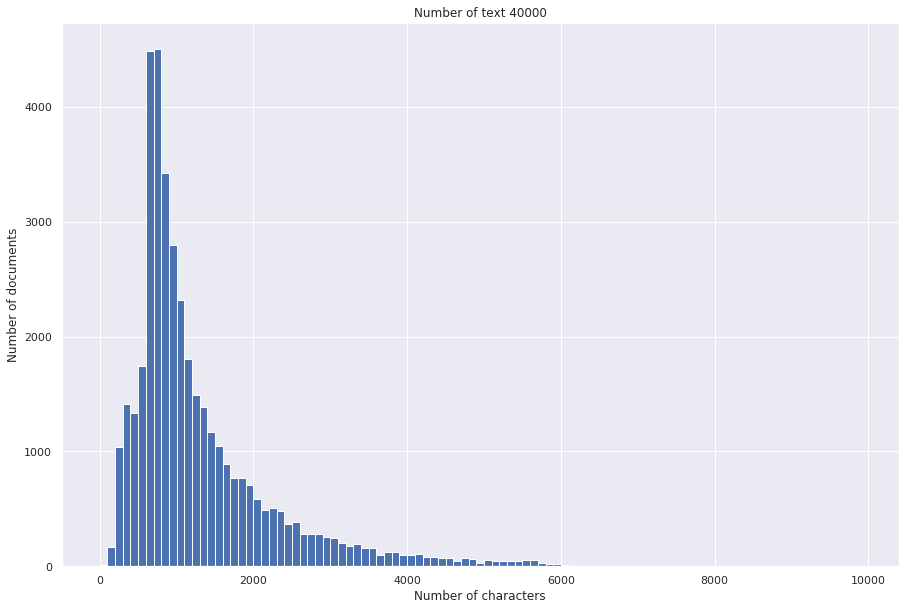

In [15]:
# ---- Show the number of characters per document
plt.figure(figsize=(15,10))
max_x = 10000 if df.char_count.max()>10000 else df.char_count.max()
plt.hist(df.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Number of {TEXT} {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

---

<center><h3>Classes repartition</h3></center>

---

Text(0.5, 1.0, 'Class Frequency')

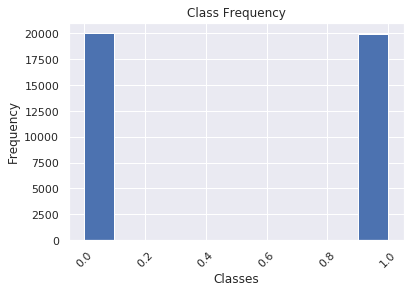

In [52]:
# ---- histogram of the class frequency
df[LABEL].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")

---

<center><h3>Unigrams</h3></center>

---

In [16]:
# ---- Load french stopwords 
if language=="fr":
    stop_word = np.loadtxt("stopwords-fr/stopwords-fr.txt", dtype=str)
if language=="en":
    stop_word = np.loadtxt("stopwords_en.txt", dtype=str)

---

In [17]:
number = 20
common_words = preproc.get_top_n_words(df[TEXT], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

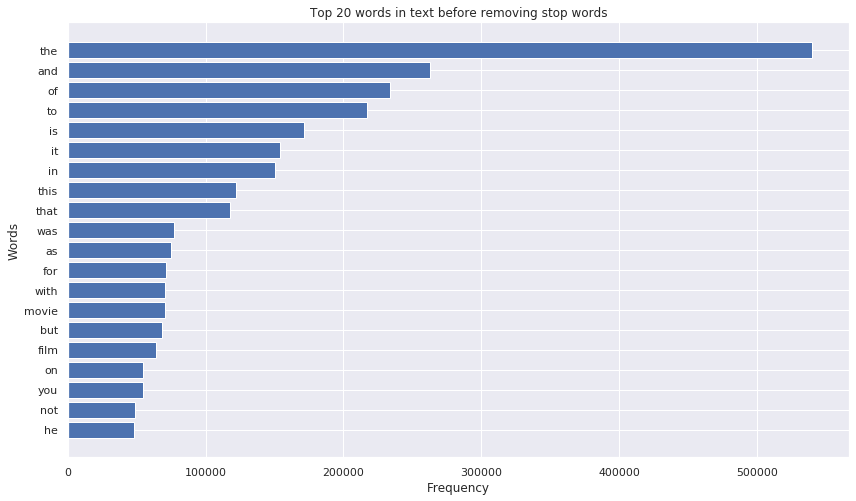

In [18]:
plt.figure(figsize=(14,8))
plt.barh(df1["words"][::-1], df1["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

---

<center><h3>Unigrams without stopwords</h3></center>

---

In [19]:
number=20
common_words = preproc.get_top_n_words_sw(df[TEXT], stop_word, language, number)
df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

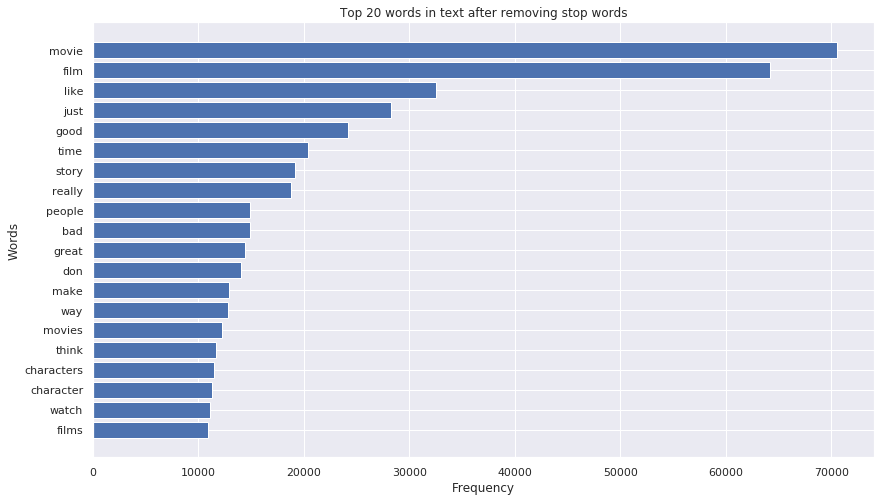

In [20]:
plt.figure(figsize=(14,8))
plt.barh(df2["words"][::-1], df2["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

---

<center><h3>Bigrams</h3></center>

---

In [21]:
number = 20
common_words = preproc.get_top_n_bigram(df[TEXT], number)

In [22]:
df3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

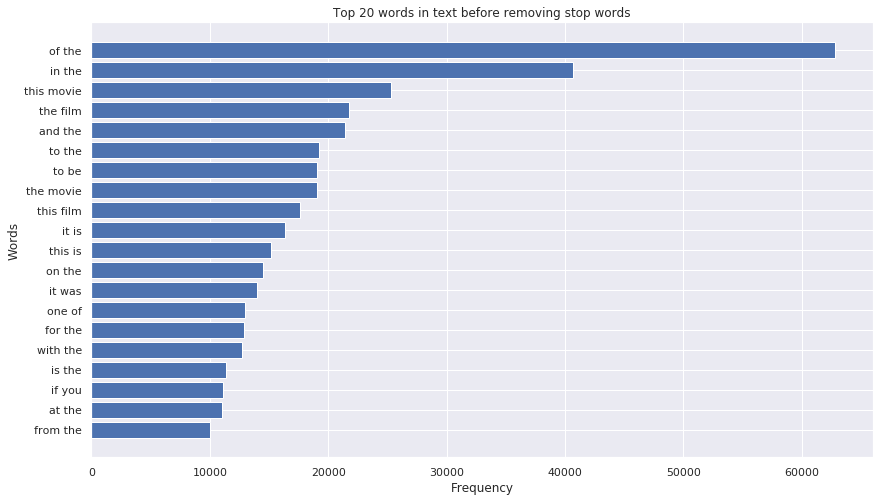

In [23]:
plt.figure(figsize=(14,8))
plt.barh(df3["words"][::-1], df3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

---

<center><h3>Bigrams without stopwords</h3></center>

---

In [34]:
number = 20
common_words = preproc.get_top_n_bigram_sw(df[TEXT], stop_word, language, number)

In [35]:
df4 = pd.DataFrame(common_words, columns = ['words' , 'count'])

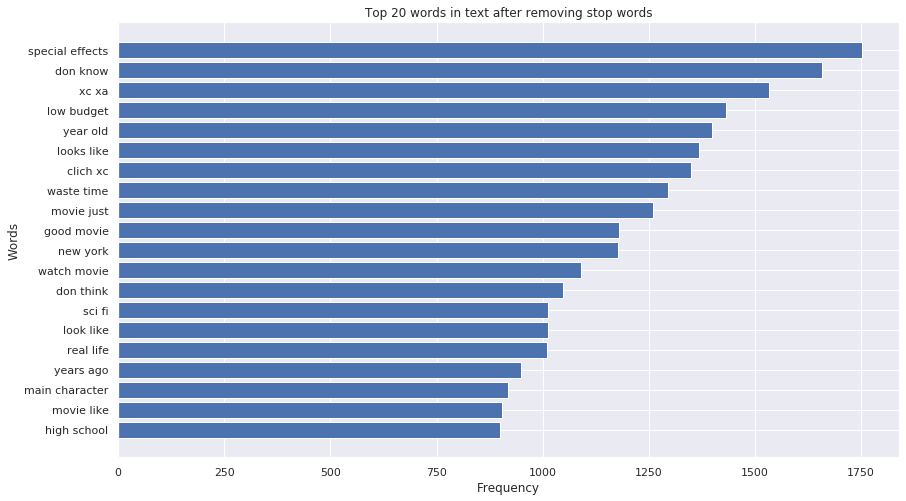

In [36]:
plt.figure(figsize=(14,8))
plt.barh(df4["words"][::-1], df4["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

---

<center><h3>Trigrams</h3></center>

---

In [27]:
number = 20
common_words = preproc.get_top_n_trigram(df[TEXT], number)

In [28]:
df5 = pd.DataFrame(common_words, columns = ['words' , 'count'])

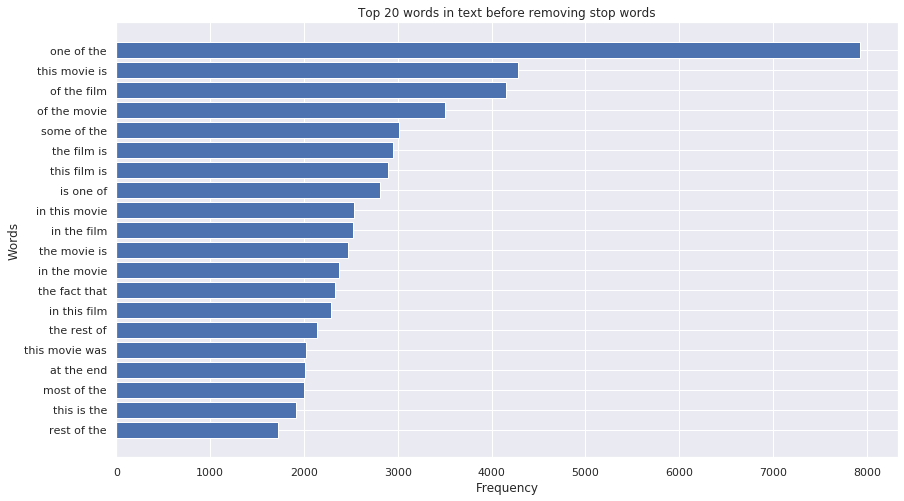

In [29]:
plt.figure(figsize=(14,8))
plt.barh(df5["words"][::-1], df5["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

---

<center><h3>Trigrams without stop words</h3></center>

---

In [37]:
number = 30
common_words = preproc.get_top_n_trigram_sw(df[TEXT], stop_word, language, number)

In [38]:
df6 = pd.DataFrame(common_words, columns = ['words' , 'count'])

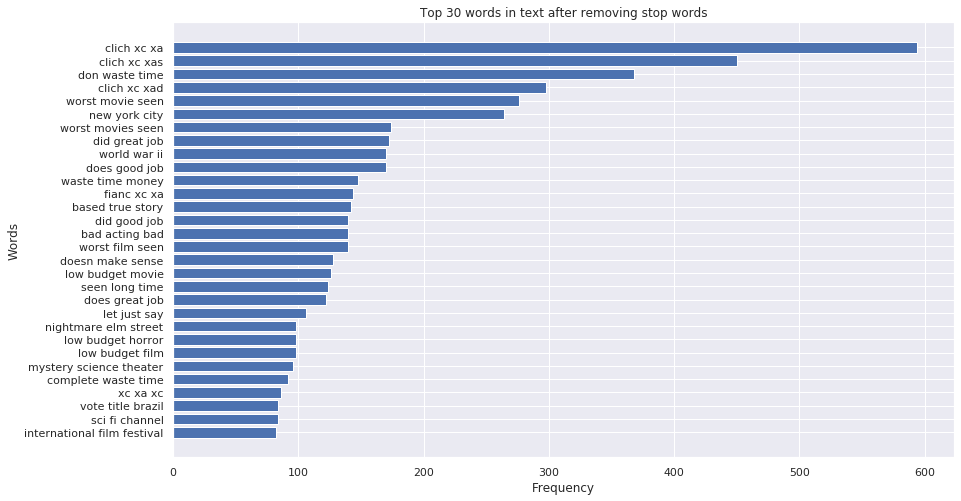

In [39]:
plt.figure(figsize=(14,8))
plt.barh(df6["words"][::-1], df6["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)
#plt.savefig("trigram_sw.png")

---

<center><h3>Part-of-Speech Tagging (POS)</h3></center>

---

In [29]:
def func_pos_ner_lemma(df, column, lang="fr"):
    '''
    Function to do part-of-speech with stanza librairy. The pipeline is configured to 
    tokenize, mwt, pos, lemma, ner parameters, it will does part-of-speech, lemmatized words
    and name entity recognition.
    @param df: (pandas.dataframe) dataframe containing the data
    @param column: (str) name of the column containing text
    @param lang: (str) language of the text
    '''
    print("Building an French pipeline...")
    nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,ner") # creation of the pipeline
    text_lem = []
    text_pos = []
    text_ner = []
    for i in tqdm(df[column]): # loop on each text 
        doc = nlp(i) # fit the text with the pipeline 
        try:
            text_lem.append(' '.join([word.lemma for sent in doc.sentences for word in sent.words])) # lemmatize 
        except: # if 
            text_lem.append('') 
        try:
            text_pos.append(' '.join([f'word: {word.text} upos: {word.upos} xpos: {word.xpos} feats: \
            {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words])) # pos 
        except:
            text_pos.append('')
        try:
            text_ner.append(' '.join([f'token: {token.text} ner: {token.ner}' for sent in doc.sentences for token in sent.tokens])) # NER
        except:
            text_ner.append('')
            
    df.loc[:,column+"_lemma"] = text_lem
    df.loc[:,column+"_pos"] = text_pos
    df.loc[:,column+"_ner"] = text_ner
    
    return df

In [30]:
if part_of_speech:
    df = func_pos_ner_lemma(df, TEXT, lang=language)

---

<center><h3>Topic Modeling Review Text</h3></center>

---

---

<center><h3>Prepare data for ML Classic</h3></center>

---

In [40]:
df.loc[:,TEXT+"_sw"] = df.loc[:,TEXT].apply(lambda x : preproc.func_remove_stop_words(x, stop_word))

In [9]:
df[LABEL][df[LABEL]!="annulation"] = "other"

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df[LABEL].value_counts()

0    20062
1    19938
Name: label, dtype: int64

---

---

<h1><center>Machine Learning</center></h1>

---

---

In [42]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(df[TEXT+"_sw"], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df[TEXT], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<center><h3>Class Weight</h3></center>

---

In [43]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [44]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 0.9969	class: 0
Class weight: 1.0031	class: 1


In [45]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 


The dataset is balanced (ratio=0.994)


---

<h2>Save Unique Labels</h2>

---

In [88]:
# Keep the unique label corresponding to their encoding correspondance
labels = df[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()

---

In [47]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT]+"_sw")

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

In [48]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df[TEXT]+"_sw")
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df[TEXT+"_sw"])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) #token_pattern=r'\w{1,}',
tfidf_vect_ngram_chars.fit(df[TEXT+"_sw"])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done


---

<h2>Load Pre-Trained model fastText</h2>

---

In [49]:
if language=="fr":
    pretrained = fasttext.FastText.load_model('fastText/cc.fr.300.bin')
if language=="en":
    pretrained = fasttext.FastText.load_model('fastText/crawl-300d-2M-subword.bin')
        

---

<h2>Word Embeddings</h2>

---

In [50]:
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 77594/77594 [00:02<00:00, 33958.42it/s]


In [20]:
lda=False
if lda:
    # train a LDA Model
    lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
    X_topics = lda_model.fit_transform(xtrain_count)
    topic_word = lda_model.components_ 
    vocab = count_vect.get_feature_names()

    # view the topic models
    n_top_words = 10
    topic_summaries = []
    for i, topic_dist in tqdm(enumerate(topic_word)):
        topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
        topic_summaries.append(' '.join(topic_words))

In [51]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

---

<center><h2>Sklearn Pipeline</h2></center>

---

<h3><i>Regression Logistic</i></h3>

In [52]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', linear_model.LogisticRegression())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 92.18%


In [53]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', svm.LinearSVC())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 96.9%


In [54]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', naive_bayes.MultinomialNB())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 89.49%


In [55]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', naive_bayes.BernoulliNB())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 88.49%


In [57]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', ensemble.GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.001,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55))])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 60.29%


In [58]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=2020))])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 70.85%


In [59]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', linear_model.SGDClassifier())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 92.21%


In [60]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', tree.DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 74.66%


In [61]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', ensemble.RandomForestClassifier())])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 96.88%


In [62]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', neighbors.KNeighborsClassifier(n_neighbors = 20,weights = 'distance',algorithm = 'brute'))])

model = pipe.fit(train_x_sw, train_y_sw)
prediction = model.predict(valid_x_sw)
print("accuracy: {}%".format(round(accuracy_score(valid_y_sw, prediction)*100,2)))

accuracy: 95.7%


---

<center><h2>Multinomial Naive Bayes</h2></center>

---

In [63]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y_sw, xvalid_tfidf)
print( "NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y_sw, xvalid_tfidf_ngram)
print( "NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y_sw, xvalid_tfidf_ngram_chars)
print( "NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.891375
NB, WordLevel TF-IDF:  0.8565
NB, N-Gram Vectors:  0.825875
NB, CharLevel Vectors:  0.813375


---

<center><h2>Logistic Regression</h2></center>

---

In [64]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_count, train_y_sw, xvalid_count)
print( "LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf, train_y_sw, xvalid_tfidf)
print( "LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram, train_y_sw, xvalid_tfidf_ngram)
print( "LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram_chars, train_y_sw, xvalid_tfidf_ngram_chars)
print( "LR, CharLevel Vectors: ", accuracy)

LR, Count Vectors:  0.9755
LR, WordLevel TF-IDF:  0.90375
LR, N-Gram Vectors:  0.842375
LR, CharLevel Vectors:  0.864


---

<center><h2>SVM</h2></center>

---

In [65]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y_sw, xvalid_tfidf_ngram)
print( "SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.943


---

<center><h2>RandomForest</h2></center>

---

<i><h3>RandomForest Count Vectors</h3></i>

In [66]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y_sw, xvalid_count)
print( "RF, Count Vectors: ", accuracy)

RF, Count Vectors:  0.9715


<i><h3>RandomForest TF-IDF</h3></i>

In [67]:
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y_sw, xvalid_tfidf)
print( "RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  0.968


---

<center><h2>Gradient Boosting</h2></center>

---

In [164]:
def func_gradientboosting(X_train, y_train, X_test, y_test):
    start = time.time()
    n_gbes = []
    score_gbes = []
    time_gbes = []
    n_estimators = 1000
    # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
    gbes = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0)
    gbes.fit(X_train, y_train)
    time_gbes.append(time.time() - start)
    
    pred = gbes.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)
    
    return gbes, pred, time_gbes, gbes.score(X_test, y_test), gbes.n_estimators_


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 131.536 s
Score : 87.98 %
Number of estimators : 62

Classification Report

              precision    recall  f1-score   support

  annulation       0.91      0.82      0.86      2371
       other       0.86      0.93      0.89      2896

    accuracy                           0.88      5267
   macro avg       0.88      0.87      0.88      5267
weighted avg       0.88      0.88      0.88      5267


Confusion Matrix





Model: f1-score=0.895 AUC=0.953




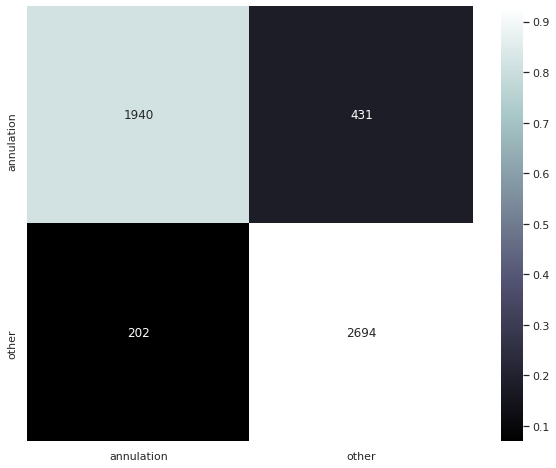

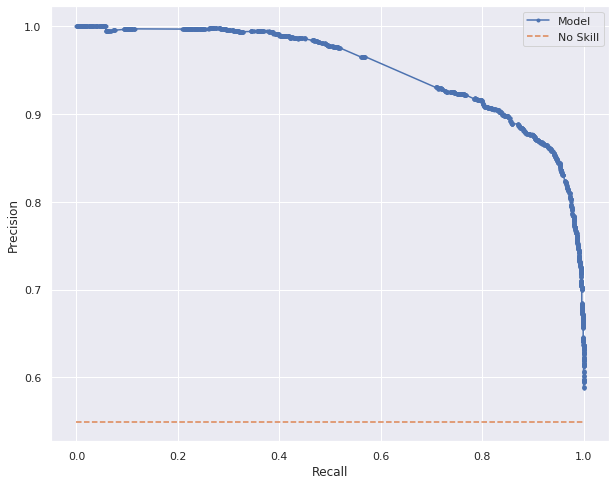




ROC AUC=0.946 



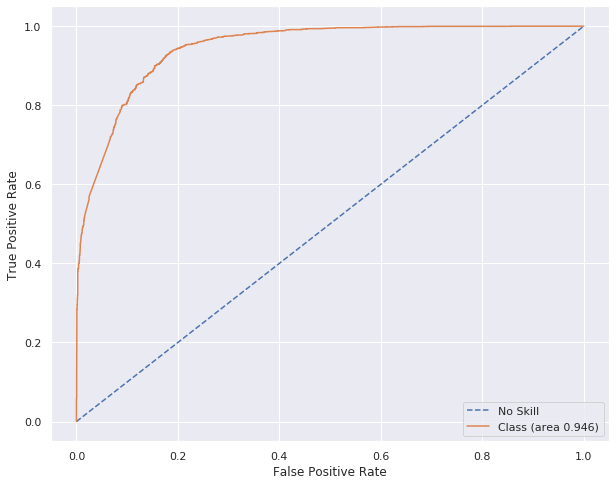



Cohen's kappa: 75.51%




In [165]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Count Vectors\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_count.tocsc(), train_y_sw, xvalid_count.tocsc(), valid_y_sw)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.func_precision_recall_curve(gbes,  xvalid_count.tocsc(), valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(gbes,  xvalid_count.tocsc(), valid_y_sw, labels, gb=True)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 22.442 s
Score : 87.79 %
Number of estimators : 58

Classification Report

              precision    recall  f1-score   support

  annulation       0.90      0.82      0.86      2371
       other       0.86      0.93      0.89      2896

    accuracy                           0.88      5267
   macro avg       0.88      0.87      0.88      5267
weighted avg       0.88      0.88      0.88      5267


Confusion Matrix





Model: f1-score=0.893 AUC=0.953




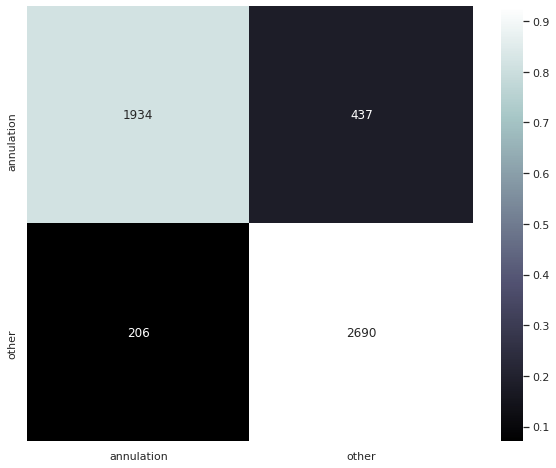

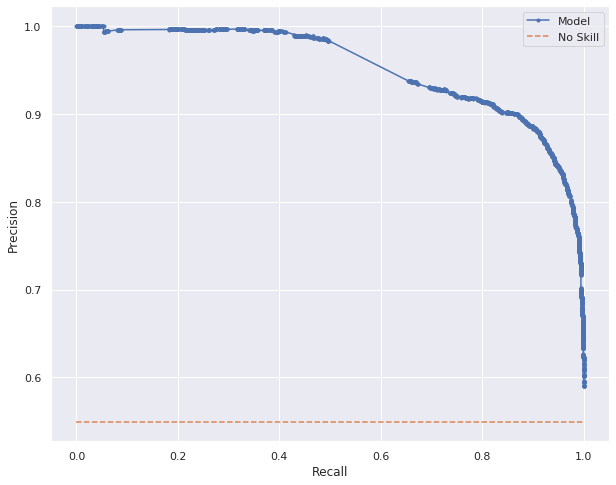




ROC AUC=0.947 



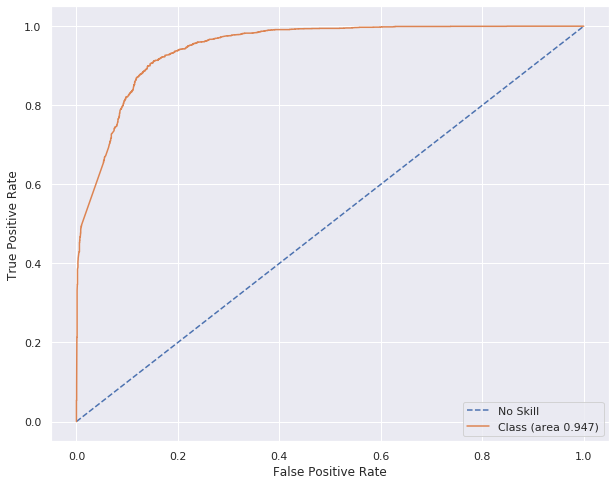



Cohen's kappa: 75.12%




In [166]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf.tocsc(), train_y_sw, xvalid_tfidf.tocsc(), valid_y_sw)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.func_precision_recall_curve(gbes,  xvalid_tfidf.tocsc(), valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(gbes,  xvalid_tfidf.tocsc(), valid_y_sw, labels, gb=True)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 25.413 s
Score : 85.21 %
Number of estimators : 66

Classification Report

              precision    recall  f1-score   support

  annulation       0.93      0.73      0.82      2371
       other       0.81      0.95      0.88      2896

    accuracy                           0.85      5267
   macro avg       0.87      0.84      0.85      5267
weighted avg       0.86      0.85      0.85      5267


Confusion Matrix





Model: f1-score=0.877 AUC=0.934




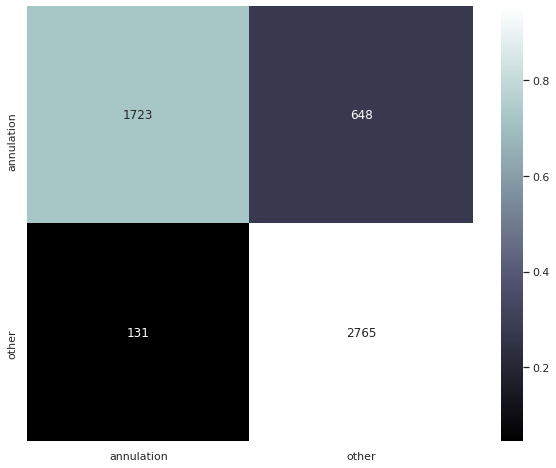

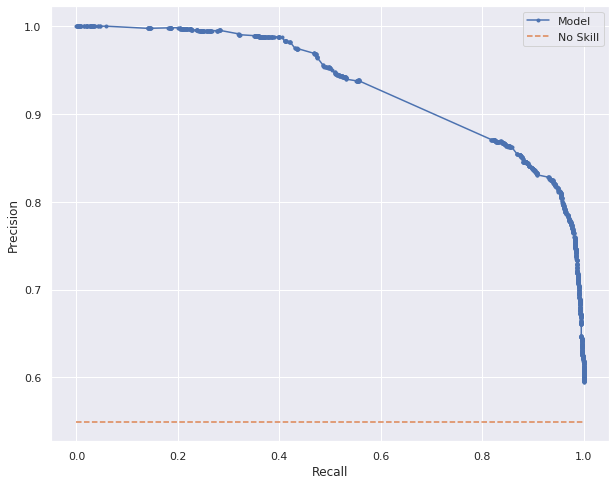




ROC AUC=0.924 



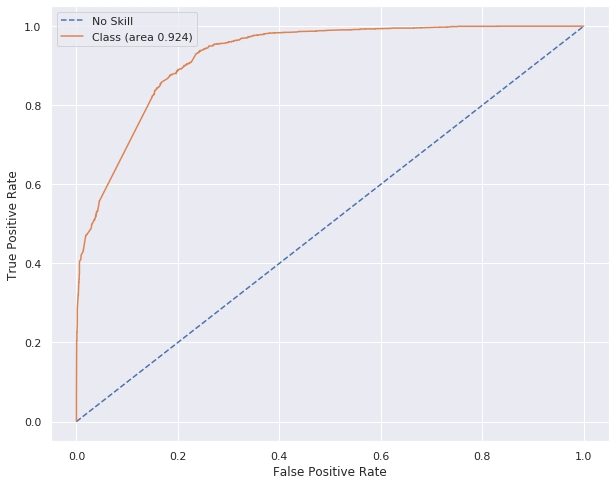



Cohen's kappa: 69.52%




In [167]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf_ngram, train_y_sw, xvalid_tfidf_ngram, valid_y_sw)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.func_precision_recall_curve(gbes,  xvalid_tfidf_ngram, valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(gbes,  xvalid_tfidf_ngram, valid_y_sw, labels, gb=True)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 210.088 s
Score : 88.87 %
Number of estimators : 57

Classification Report

              precision    recall  f1-score   support

  annulation       0.90      0.84      0.87      2371
       other       0.88      0.93      0.90      2896

    accuracy                           0.89      5267
   macro avg       0.89      0.88      0.89      5267
weighted avg       0.89      0.89      0.89      5267


Confusion Matrix





Model: f1-score=0.902 AUC=0.956




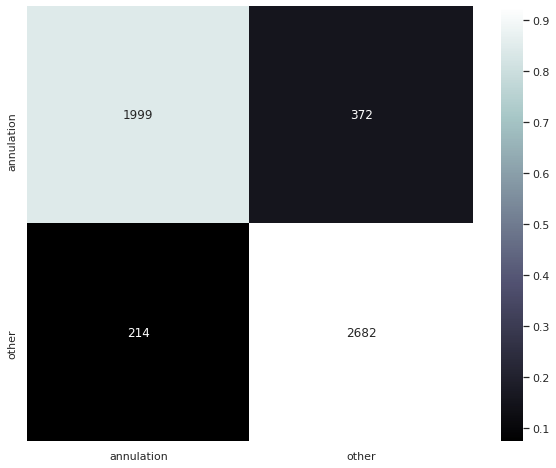

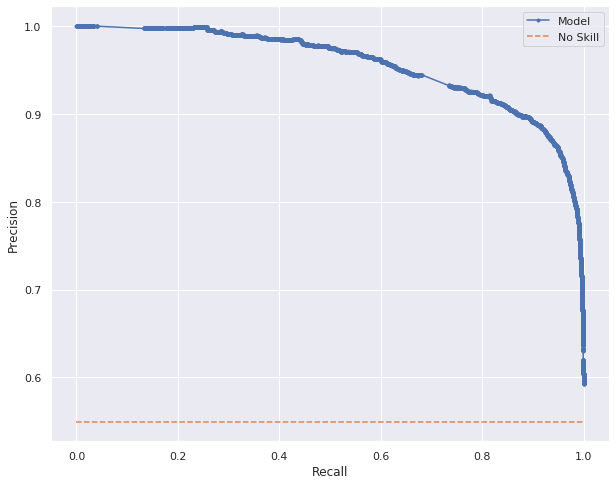




ROC AUC=0.951 



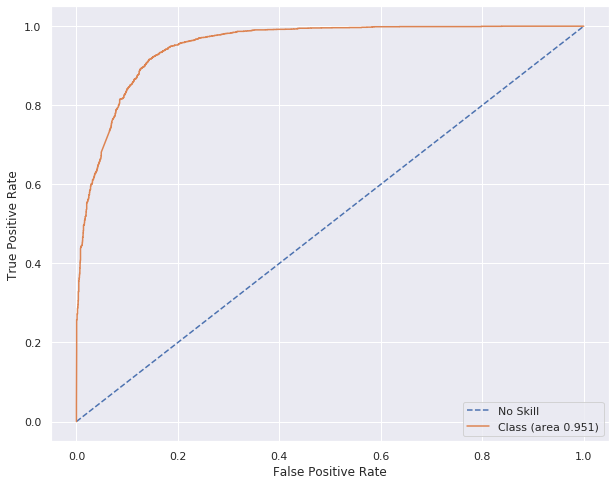



Cohen's kappa: 77.39%




In [168]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf_ngram_chars.tocsc(), train_y_sw, xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.func_precision_recall_curve(gbes,  xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(gbes,  xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw, labels, gb=True)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")


Gradient Boosting with early stopping for Word Embeddings

Early Stopping : 5 iterations without change
Execution time : 23.819 s
Score : 75.09 %
Number of estimators : 42

Classification Report

              precision    recall  f1-score   support

  annulation       0.76      0.65      0.70      2371
       other       0.74      0.84      0.79      2896

    accuracy                           0.75      5267
   macro avg       0.75      0.74      0.74      5267
weighted avg       0.75      0.75      0.75      5267


Confusion Matrix





Model: f1-score=0.787 AUC=0.818




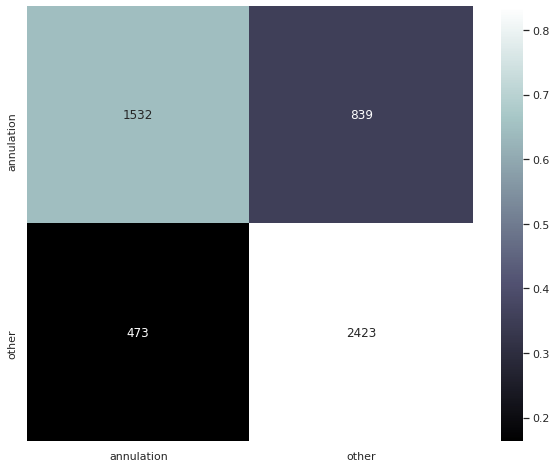

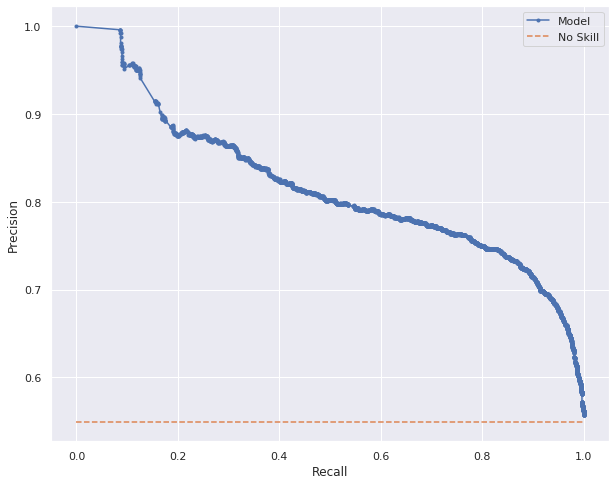




ROC AUC=0.808 



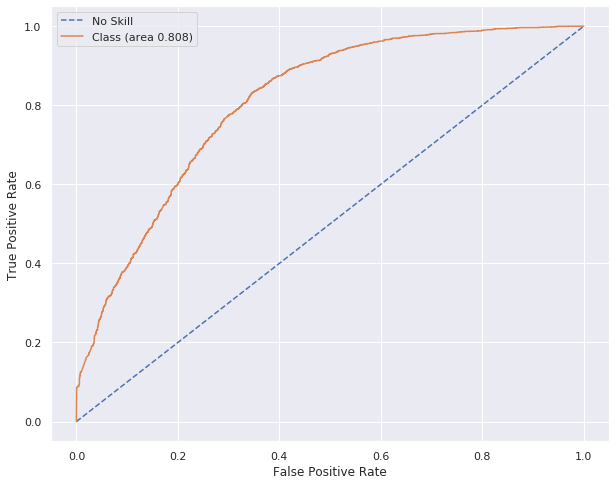



Cohen's kappa: 48.97%




In [169]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Word Embeddings\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(train_seq_x, train_y, valid_seq_x, valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.func_precision_recall_curve(gbes,  valid_seq_x, valid_y, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(gbes,  valid_seq_x, valid_y, labels, gb=True)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")

---

<h2>XGBoost Classifier</h2>

---

All the XGBoost have early stopping implemented with 10 rounds

In [68]:
def func_xgb(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))



<i><h3>XGBoost for Count Vectors</h3></i>


XGBoost for Count Vectors


Classification Report

              precision    recall  f1-score   support

     negtive       0.97      0.97      0.97      4012
    positive       0.97      0.97      0.97      3988

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Confusion Matrix



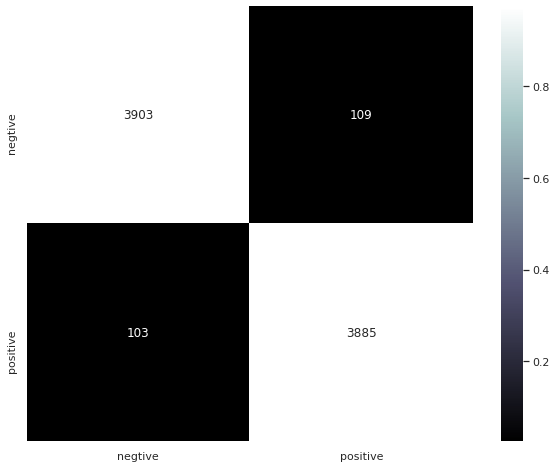

In [81]:
if xgboost_classifier:
    print("\nXGBoost for Count Vectors\n")
    xgbs, pred, accuracy = func_xgb(xtrain_count.tocsc(), train_y_sw, xvalid_count.tocsc(), valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)



Model: f1-score=0.973 AUC=0.989




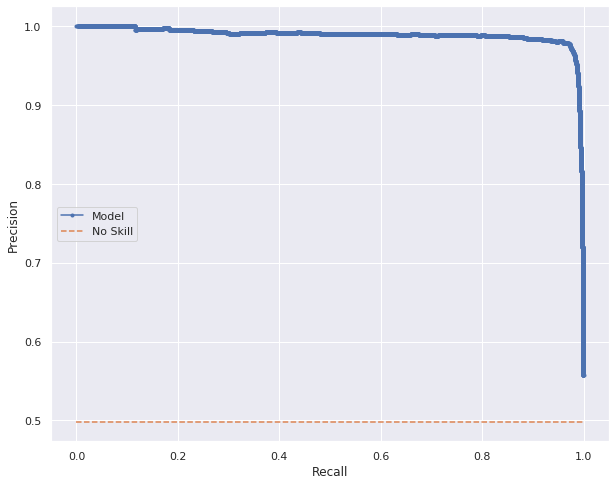




ROC AUC=0.991 



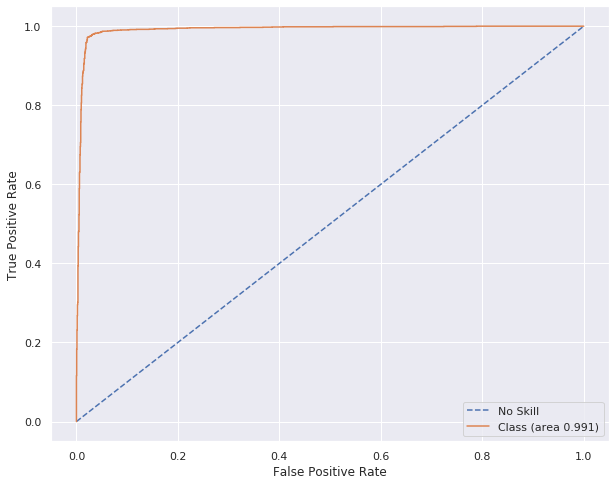


Evaluation Curves


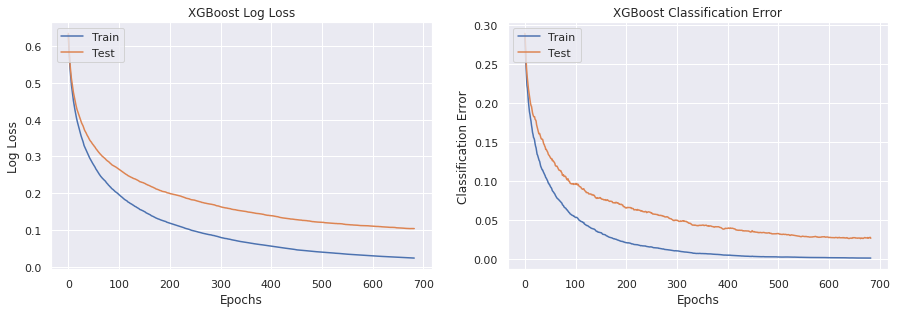



Cohen's kappa: 94.7%




In [82]:
if xgboost_classifier:
    Metric.func_precision_recall_curve(xgbs,  xvalid_count.tocsc(),  valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(xgbs, xvalid_count.tocsc(), valid_y_sw,  labels, gb=True)
    print("\nEvaluation Curves")
    Metric.func_plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_count.tocsc())),2)}%\n\n")

<i><h3>XGBoost for TF-IDF </h3></i>


XGBoost for TF_IDF


Accuracy: 97.31%

Classification Report

              precision    recall  f1-score   support

    negative       0.98      0.97      0.97      4012
    positive       0.97      0.98      0.97      3988

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Confusion Matrix



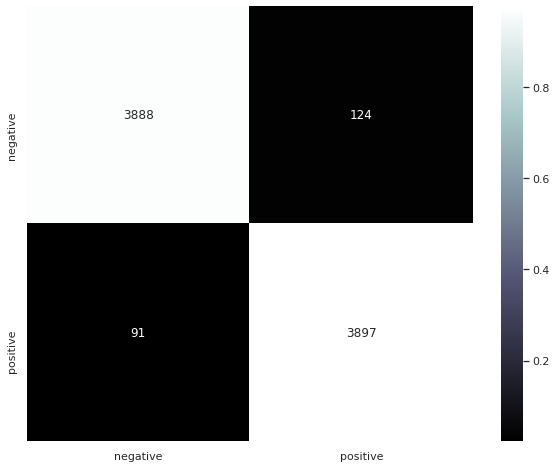

In [89]:
if xgboost_classifier:
    print("\nXGBoost for TF-IDF\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf.tocsc(), train_y_sw, xvalid_tfidf.tocsc(), valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)




Model: f1-score=0.973 AUC=0.991




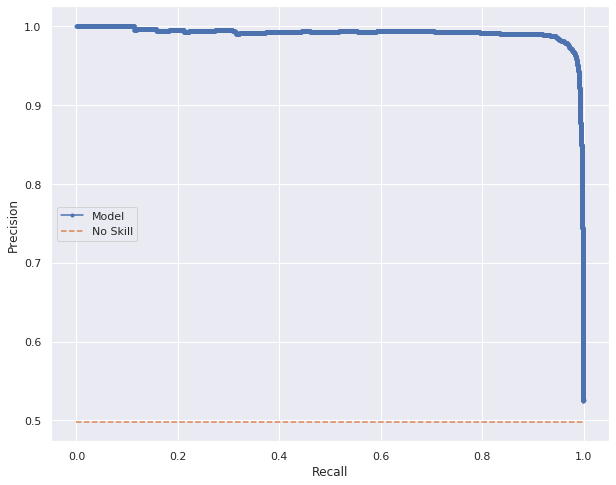




ROC AUC=0.993 



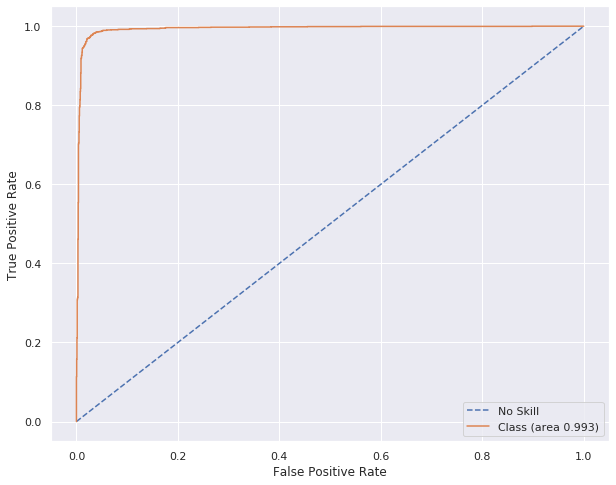


Evaluation Curves


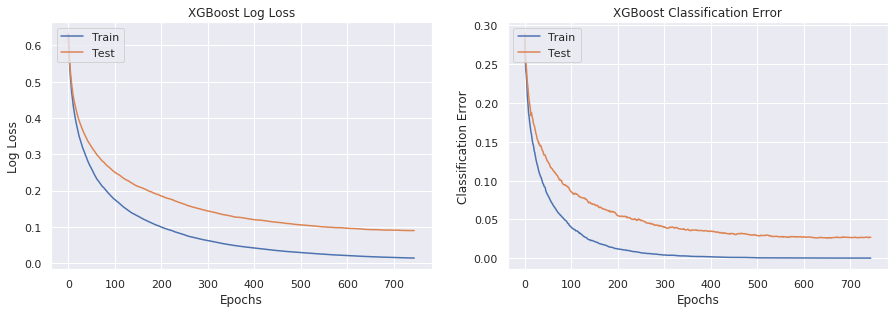



Cohen's kappa: 94.63%




In [90]:
if xgboost_classifier:
    Metric.func_precision_recall_curve(xgbs,  xvalid_tfidf.tocsc(), valid_y_sw,  labels,gb=True)
    print("\n")
    Metric.func_roc_auc_curve(xgbs,  xvalid_tfidf.tocsc(), valid_y_sw, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.func_plot_eval_xgb(xgbs, labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  xgbs.predict(xvalid_tfidf.tocsc())),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram </h3></i>


XGBoost for TF_IDF ngram


Accuracy: 90.60%

Classification Report

              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      4012
    positive       0.90      0.92      0.91      3988

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000


Confusion Matrix



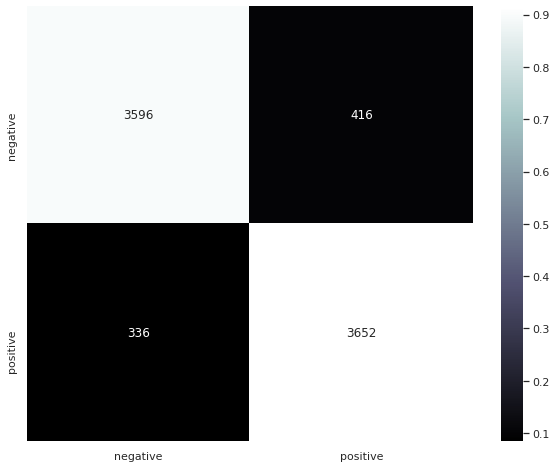

In [91]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF ngram\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf_ngram, train_y_sw, xvalid_tfidf_ngram, valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)



Model: f1-score=0.907 AUC=0.959




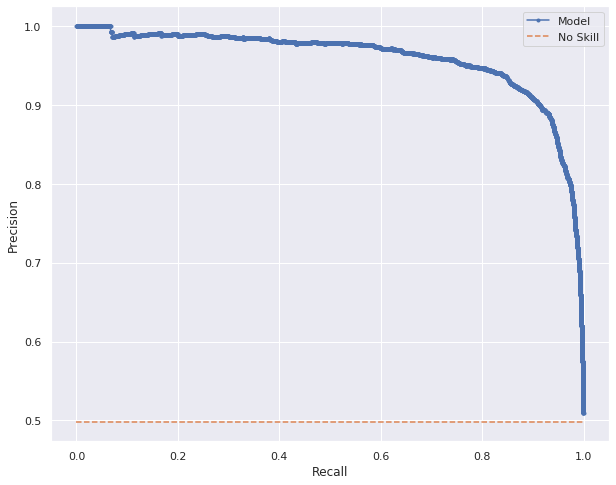




ROC AUC=0.963 



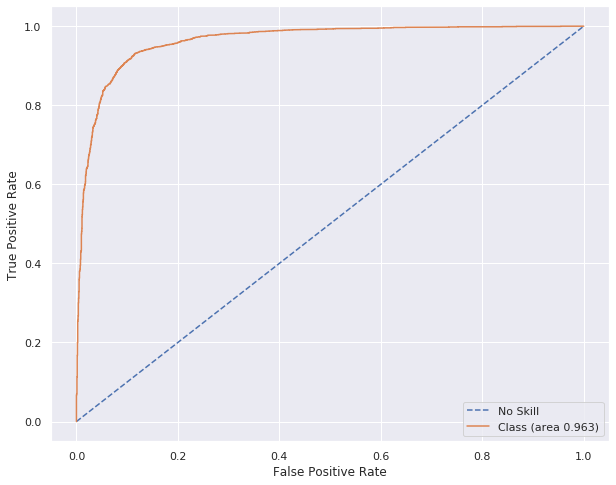


Evaluation Curves


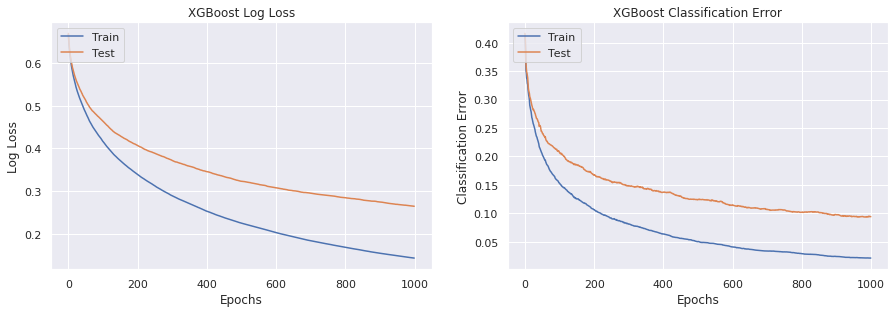



Cohen's kappa: 81.2%




In [92]:
if xgboost_classifier:
    Metric.func_precision_recall_curve(xgbs,  xvalid_tfidf_ngram, valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(xgbs,  xvalid_tfidf_ngram, valid_y_sw, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.func_plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  xgbs.predict(xvalid_tfidf_ngram)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram chars</h3></i>


XGBoost for TF-IDF ngram chars


Accuracy: 96.88%

Classification Report

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97      4012
    positive       0.97      0.97      0.97      3988

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Confusion Matrix



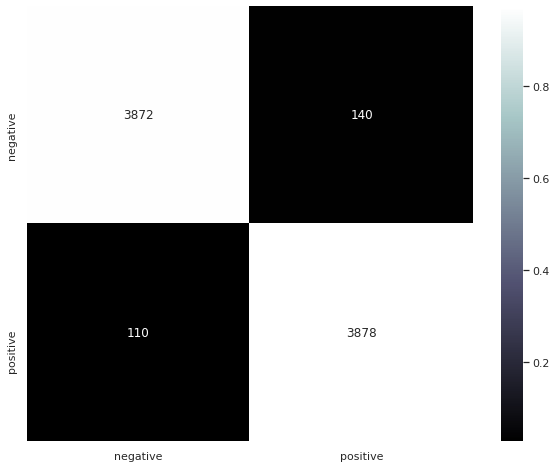

In [93]:
if xgboost_classifier:
    print("\nXGBoost for TF-IDF ngram chars\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf_ngram_chars.tocsc(), train_y_sw, xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred,target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)



Model: f1-score=0.969 AUC=0.992




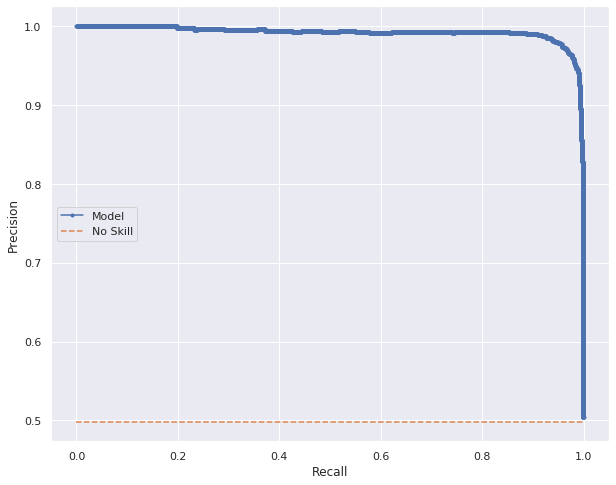




ROC AUC=0.993 



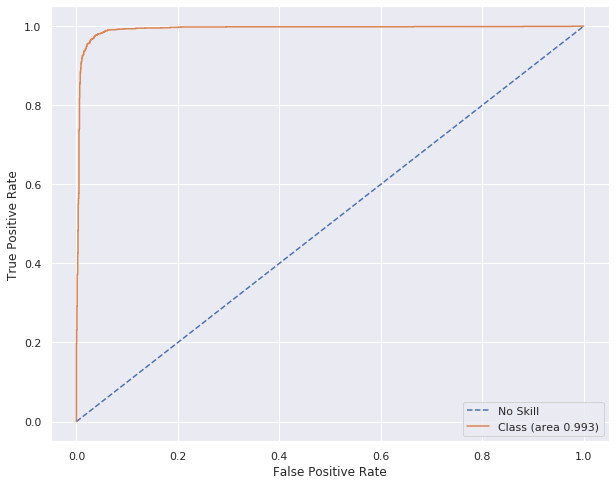


Evaluation Curves


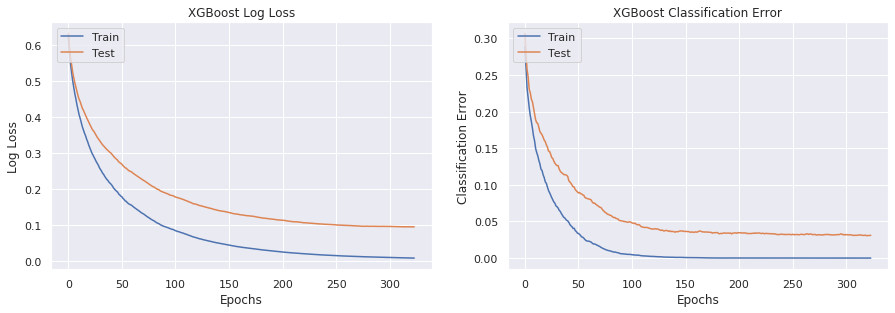



Cohen's kappa: 93.75%




In [94]:
if xgboost_classifier:
    Metric.func_precision_recall_curve(xgbs,  xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(xgbs,  xvalid_tfidf_ngram_chars.tocsc(), valid_y_sw, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.func_plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y_sw,  xgbs.predict(xvalid_tfidf_ngram_chars.tocsc())),2)}%\n\n")

<i><h3>XGBoost for Word Embeddings</h3></i>


XGBoost for Word Embeddings


Accuracy: 91.35%

Classification Report

              precision    recall  f1-score   support

    negative       0.91      0.92      0.91      4012
    positive       0.92      0.91      0.91      3988

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000


Confusion Matrix



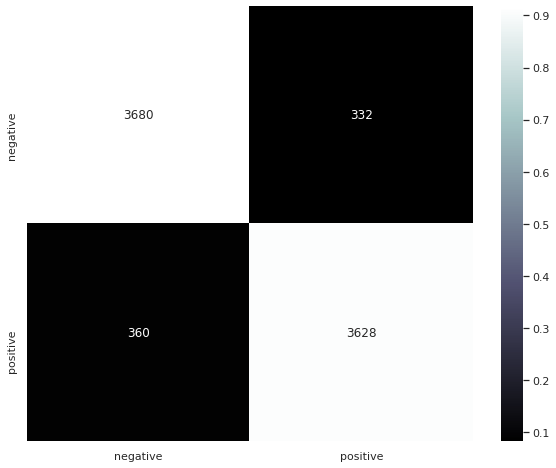

In [95]:
if xgboost_classifier:
    print("\nXGBoost for Word Embeddings\n")
    xgbs, pred, accuracy = func_xgb(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)



Model: f1-score=0.913 AUC=0.977




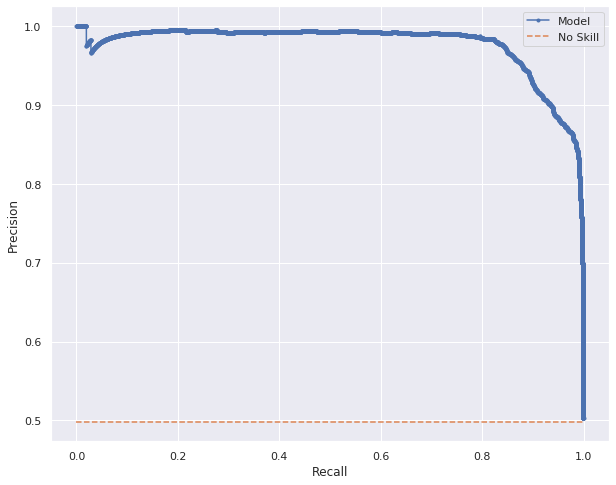




ROC AUC=0.979 



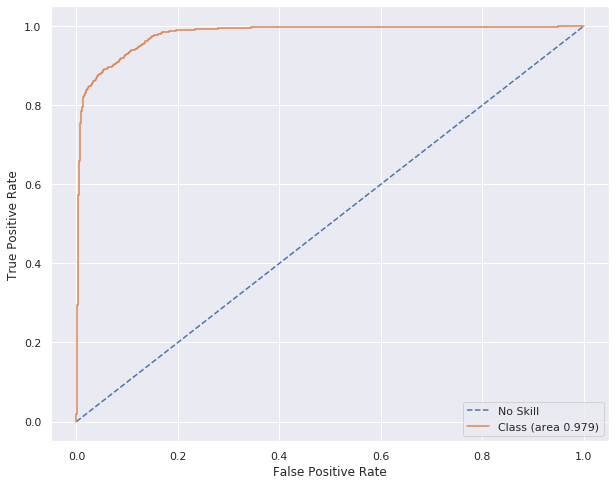


Evaluation Curves


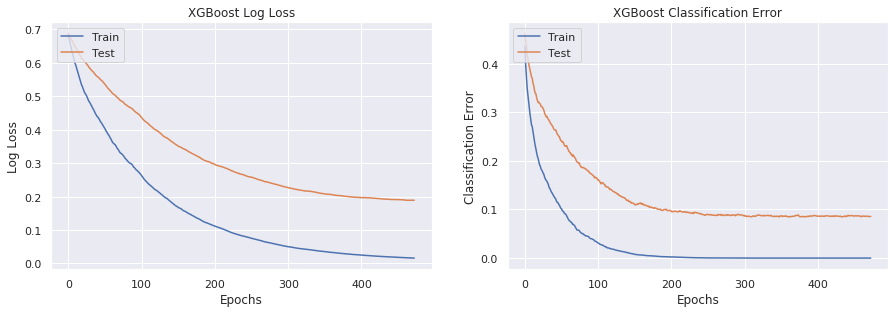



Cohen's kappa: 82.7%




In [96]:
if xgboost_classifier:
    Metric.func_precision_recall_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
    print("\n")
    Metric.func_roc_auc_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.func_plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(valid_seq_x)),2)}%\n\n")

---

<center><h1>Deep Learning</h1></center>

---

In [97]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [98]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

<h2>Shallow Neural Networks</h2>

In [99]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [100]:
if deep_learning:
    model_shallow = shallow_neural_networks(word_index, pre_trained=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1241520   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,241,537
Trainable params: 1,241,537
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
if deep_learning:
    history = model_shallow.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:28:13 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b6c09eb70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
799/800 [============================>.] - ETA: 0s - loss: 0.6977 - accuracy: 0.5016WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6c8d6400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:28:29 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6c8d6400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 15s 19ms/step - loss: 0.6977 - accuracy: 0.5016 - val_loss: 0.6870 - val_accuracy: 0.5025
Epoch 2/1000
800/800 [==============================] - 15s 19ms/step - loss: 0.6732 - accuracy: 0.5411 - val_loss: 0.6548 - val_accuracy: 0.6786
Epoch 3/1000
800/800 [==============================] - 15s 19ms/step - loss: 0.6304 - accuracy: 0.7549 - val_loss: 0.6164 - val_accuracy: 0.7984
Epoch 4/1000
800/800 [==============================] - 15s 18ms/step - loss: 0.5988 - accuracy: 0.8493 - val_loss: 0.5944 - val_accuracy: 0.8495
Epoch 5/1000
800/800 [==============================] - 15s 18ms/step - loss: 0.5797 - accuracy: 0.8825 - val_loss: 0.5812 

In [102]:
if deep_learning:
    results = model_shallow.evaluate(valid_seq_x, valid_y)
    print(results)

250/250 [==============================] - 2s 6ms/step - loss: 0.5315 - accuracy: 0.9469
[0.5314595699310303, 0.9468749761581421]


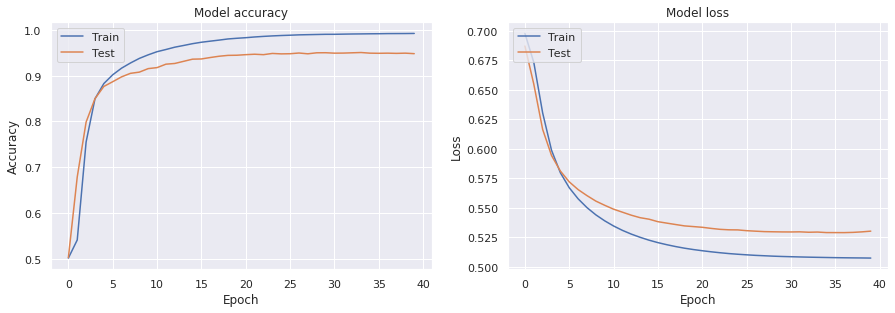

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:37:43 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b3ab78620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.95      0.94      0.95      4012
    positive       0.94      0.95      0.95      3988

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000


The balanced accuracy is : 94.69%


The Zero-one Loss is : 5.31%


Explained variance score: 0.788


ROC AUC=0.976 



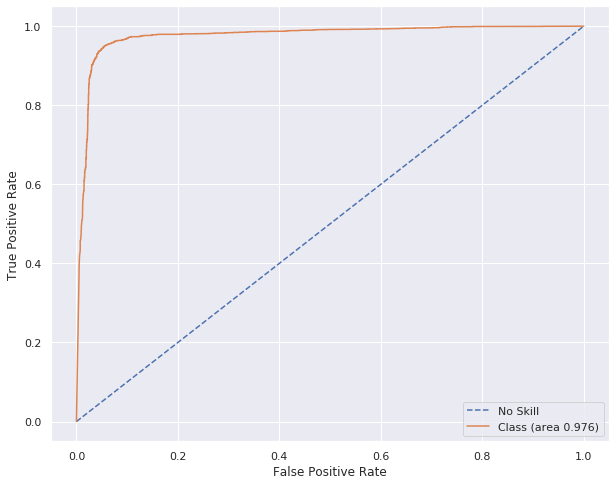



Model: f1-score=0.947 AUC=0.974




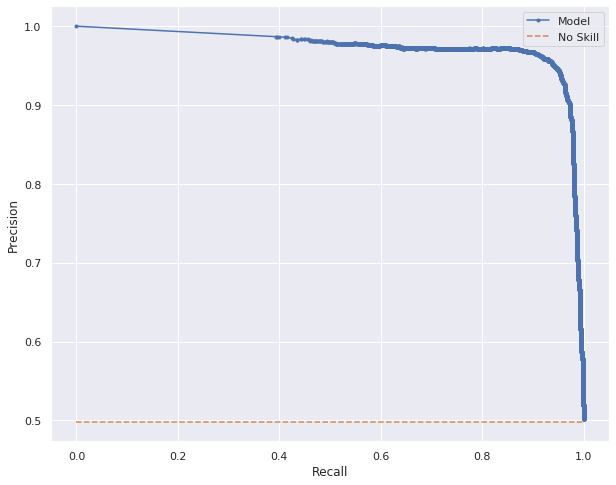


Cohen's kappa: 89.38% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



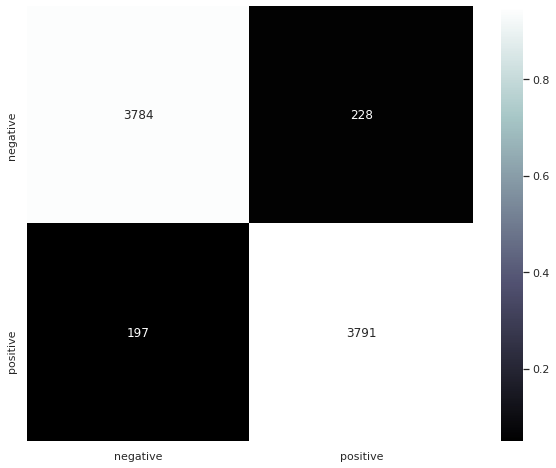

In [103]:
if deep_learning:
    Metric.func_metrics_deep_learning(model_shallow, history, valid_seq_x, valid_y, labels)

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

<h2>Deep Neural Networks</h2>

In [104]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [105]:
if deep_learning:
    model = deep_neural_networks(word_index, pre_trained=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          3879750   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,880,583
Trainable params: 3,880,583
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:37:51 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3c506158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.6084WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b42b86c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:38:48 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b42b86c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 56s 71ms/step - loss: 0.6634 - accuracy: 0.6084 - val_loss: 0.5859 - val_accuracy: 0.8456
Epoch 2/1000
800/800 [==============================] - 55s 69ms/step - loss: 0.5590 - accuracy: 0.8979 - val_loss: 0.5535 - val_accuracy: 0.9031
Epoch 3/1000
800/800 [==============================] - 73s 91ms/step - loss: 0.5351 - accuracy: 0.9417 - val_loss: 0.5437 - val_accuracy: 0.9194
Epoch 4/1000
800/800 [==============================] - 82s 103ms/step - loss: 0.5244 - accuracy: 0.9621 - val_loss: 0.5381 - val_accuracy: 0.9312
Epoch 5/1000
800/800 [==============================] - 75s 94ms/step - loss: 0.5186 - accuracy: 0.9723 - val_loss: 0.5355

In [107]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 1s 4ms/step - loss: 0.5319 - accuracy: 0.9413
[0.5319012999534607, 0.9412500262260437]


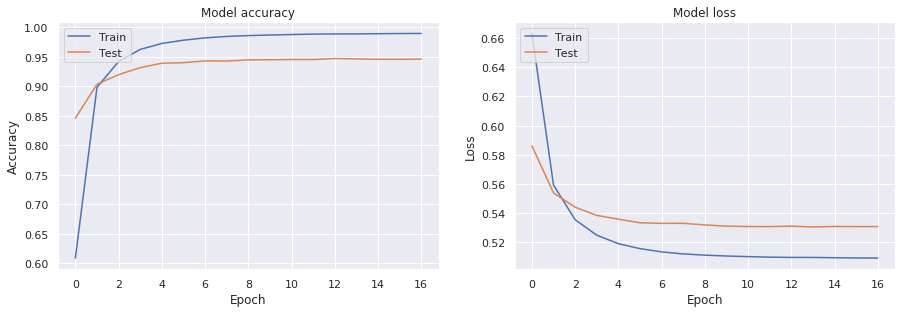

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:54:04 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b6f6549d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94      4012
    positive       0.95      0.94      0.94      3988

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000


The balanced accuracy is : 94.12%


The Zero-one Loss is : 5.87%


Explained variance score: 0.765


ROC AUC=0.972 



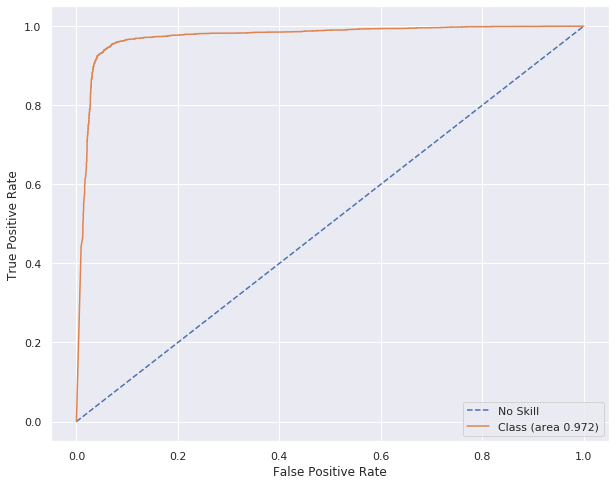



Model: f1-score=0.941 AUC=0.970




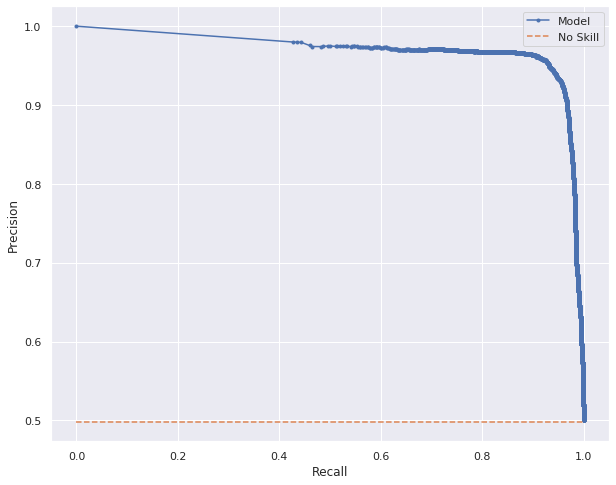


Cohen's kappa: 88.25% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



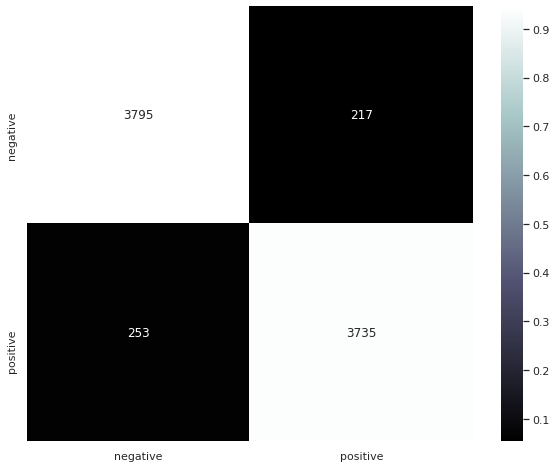

In [108]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 1</h2>

In [109]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [110]:
if deep_learning:
    model = deep_neural_networks_var1(word_index, pre_trained=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         23278500  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 23,283,605
Trainable params: 5,105
Non-trainable params: 23,278,500
_________________________________________________________________
None


In [111]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:54:13 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3d027ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:54:17 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b3f3ee400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [112]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 1s 5ms/step - loss: 0.5878 - accuracy: 0.8374
[0.5877922773361206, 0.8373749852180481]


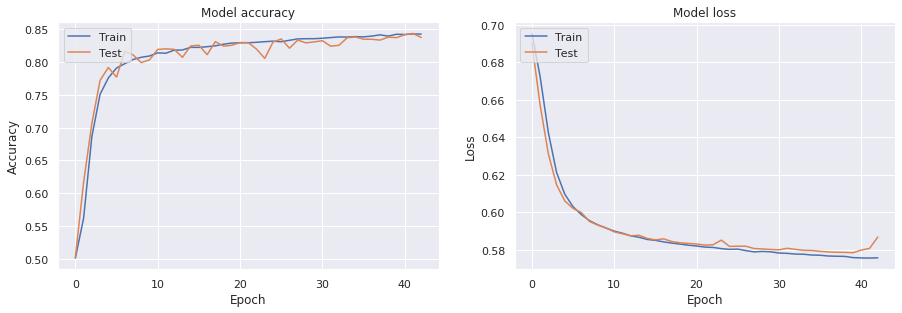

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:57:05 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b6f8d8730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83      4012
    positive       0.82      0.86      0.84      3988

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000


The balanced accuracy is : 83.74%


The Zero-one Loss is : 16.26%


Explained variance score: 0.351


ROC AUC=0.906 



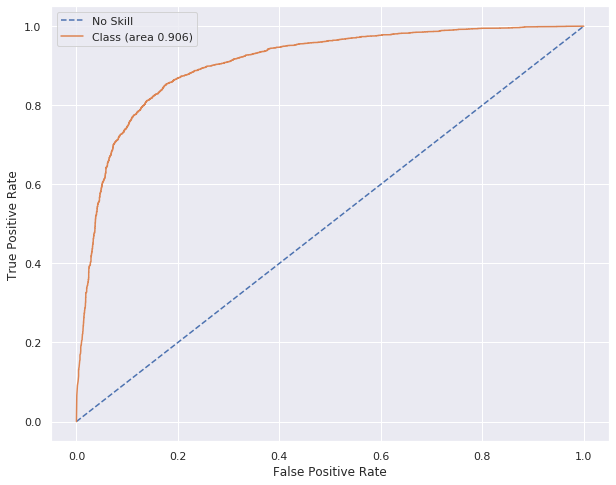



Model: f1-score=0.840 AUC=0.899




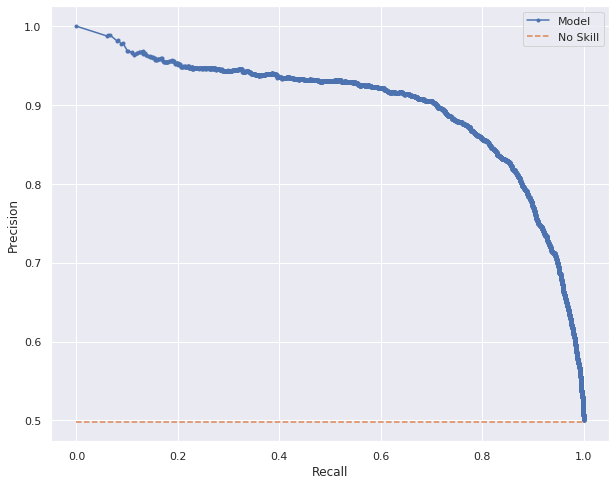


Cohen's kappa: 67.48% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



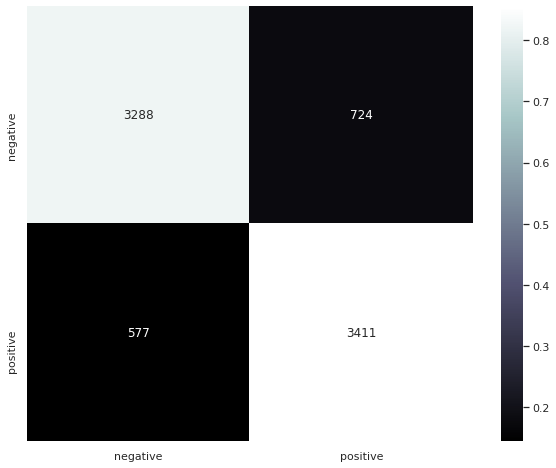

In [113]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 2</h2>

In [114]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [115]:
if deep_learning:
    model = deep_neural_networks_var2(word_index, pre_trained=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         23278500  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 23,288,677
Trainable params: 10,177
Non-trainable params: 23,278,500
_________________________________________________________________
None


In [116]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:57:16 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b8cd27a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:57:19 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6e396c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [117]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 1s 5ms/step - loss: 0.5808 - accuracy: 0.8317
[0.5808340907096863, 0.8317499756813049]


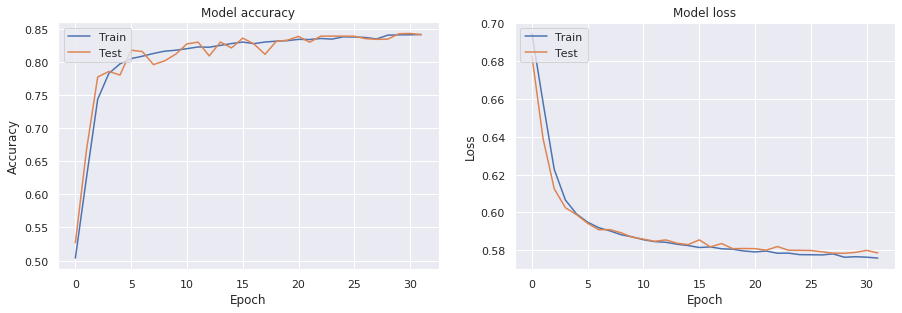

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 00:59:16 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b464ee620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      4012
    positive       0.86      0.79      0.82      3988

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000


The balanced accuracy is : 83.16%


The Zero-one Loss is : 16.83%


Explained variance score: 0.333


ROC AUC=0.903 



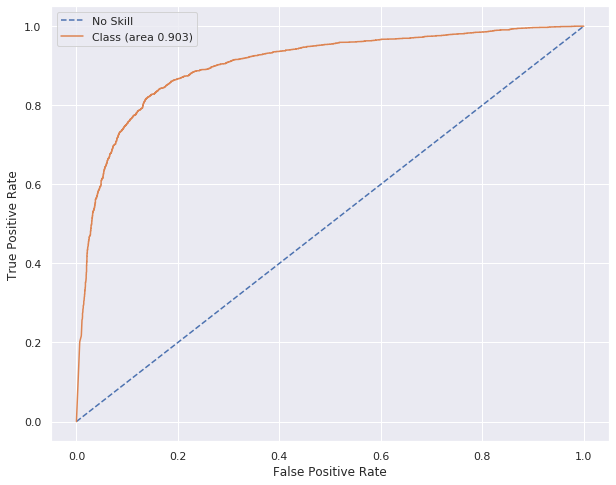



Model: f1-score=0.824 AUC=0.904




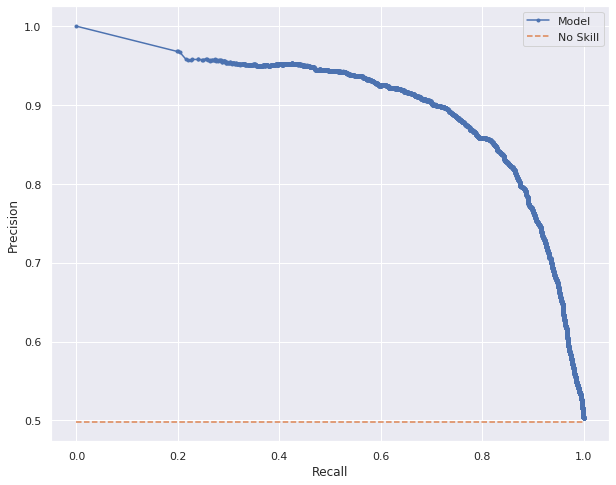


Cohen's kappa: 66.34% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



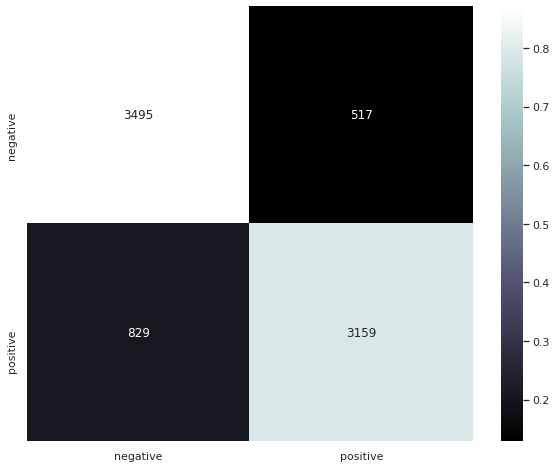

In [118]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurent Neural Network - RNN</h2>

In [172]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 32)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [173]:
if deep_learning:
    model = create_rnn_model(word_index, pre_trained=False )


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          2483040   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 2,491,393
Trainable params: 2,491,393
Non-trainable params: 0
___________________________________________

In [188]:
@tf.autograph.experimental.do_not_convert

SyntaxError: unexpected EOF while parsing (<ipython-input-188-c036b9b6d415>, line 1)

In [174]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es], batch_size=128,
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 13:56:23 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b49b2c840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5032WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b3c46ab70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 14:00:38 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b3c46ab70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 269s 336ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6929 - val_accuracy: 0.5025
Epoch 2/1000
800/800 [==============================] - 280s 350ms/step - loss: 0.6669 - accuracy: 0.5972 - val_loss: 0.6485 - val_accuracy: 0.6355
Epoch 3/1000
800/800 [==============================] - 282s 353ms/step - loss: 0.5886 - accuracy: 0.8054 - val_loss: 0.6179 - val_accuracy: 0.7617
Epoch 4/1000
800/800 [==============================] - 317s 396ms/step - loss: 0.5549 - accuracy: 0.8829 - val_loss: 0.5904 - val_accuracy: 0.8341
Epoch 5/1000
800/800 [==============================] - 290s 362ms/step - loss: 0.5428 - accuracy: 0.9093 - val_los

In [175]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 24s 96ms/step - loss: 0.6936 - accuracy: 0.5034
[0.6935750842094421, 0.5033749938011169]


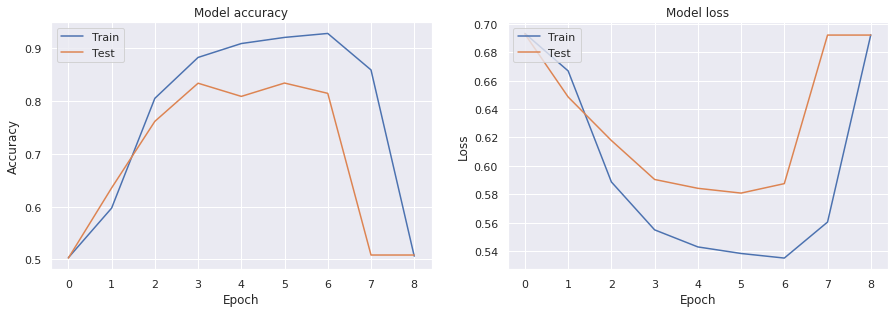

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 14:41:07 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b6ef36400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.50      0.99      0.67      4012
    positive       0.58      0.01      0.03      3988

    accuracy                           0.50      8000
   macro avg       0.54      0.50      0.35      8000
weighted avg       0.54      0.50      0.35      8000


The balanced accuracy is : 50.19%


The Zero-one Loss is : 49.66%


Explained variance score: -0.037


ROC AUC=0.632 



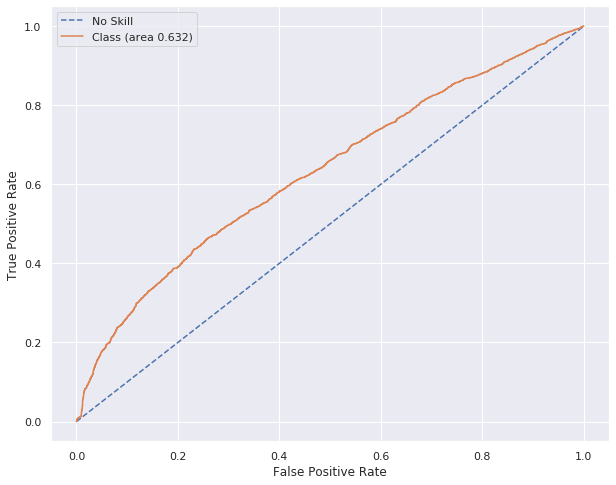



Model: f1-score=0.026 AUC=0.638




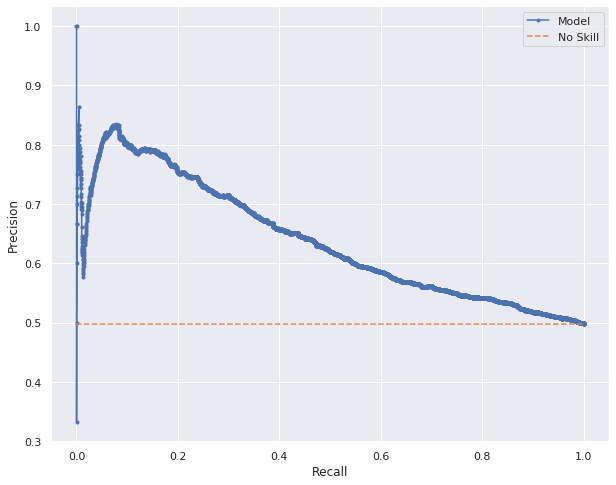


Cohen's kappa: 0.38% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



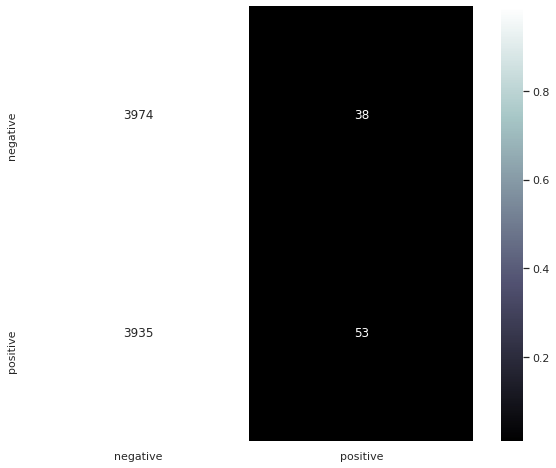

In [176]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Convolutional Neural Network</h2>

In [189]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [190]:
if deep_learning:
    model = create_conv_model(word_index, labels, pre_trained=False)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 50)          3879750   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 128)         32128     
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 64)          41024     
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 64)        

In [ ]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],batch_size=128,
                    validation_split=0.2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 16:39:47 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3b70cd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.5012WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6ce73840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 16:40:33 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6ce73840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - 48s 242ms/step - loss: 0.6977 - accuracy: 0.5012 - val_loss: 0.6953 - val_accuracy: 0.5025
Epoch 2/50
200/200 [==============================] - 51s 253ms/step - loss: 0.6868 - accuracy: 0.5014 - val_loss: 0.6846 - val_accuracy: 0.5044
Epoch 3/50
200/200 [==============================] - 50s 249ms/step - loss: 0.6402 - accuracy: 0.6753 - val_loss: 0.6295 - val_accuracy: 0.8025
Epoch 4/50
200/200 [==============================] - 50s 251ms/step - loss: 0.5812 - accuracy: 0.8546 - val_loss: 0.5941 - val_accuracy: 0.8120
Epoch 5/50
200/200 [==============================] - 52s 260ms/step - loss: 0.5573 - accuracy: 0.8948 - val_loss: 0.5755 - v

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Neural Network – LSTM</h2>

In [ ]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(64),
    keras.layers.Dense(256, activation="relu"),   
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='rmsprop',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

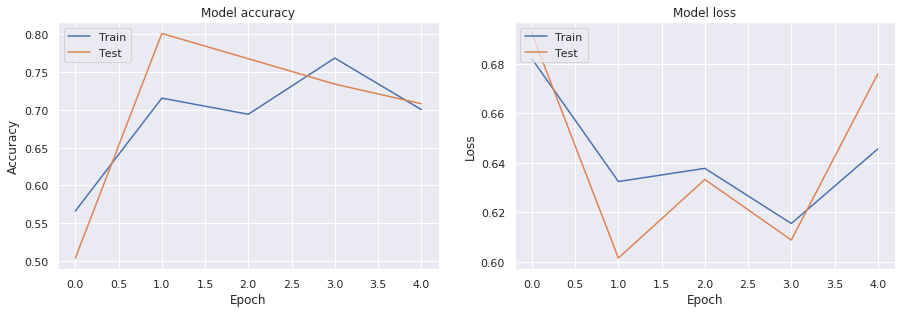

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 13:30:42 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b473f50d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.87      0.50      0.63      4012
    positive       0.65      0.93      0.76      3988

    accuracy                           0.71      8000
   macro avg       0.76      0.71      0.70      8000
weighted avg       0.76      0.71      0.70      8000


The balanced accuracy is : 71.28%


The Zero-one Loss is : 28.79%


Explained variance score: 0.032


ROC AUC=0.733 



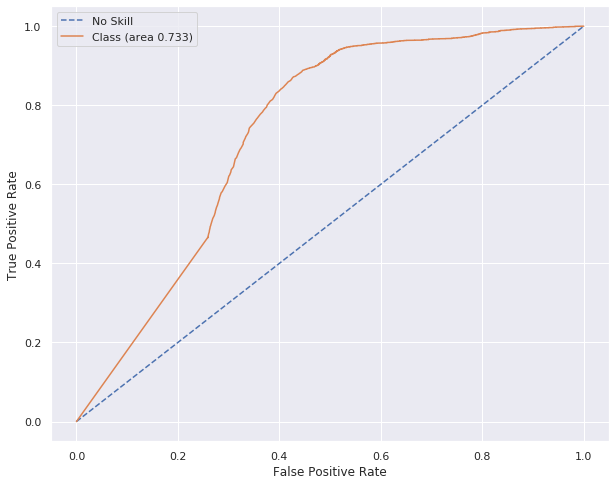



Model: f1-score=0.762 AUC=0.734




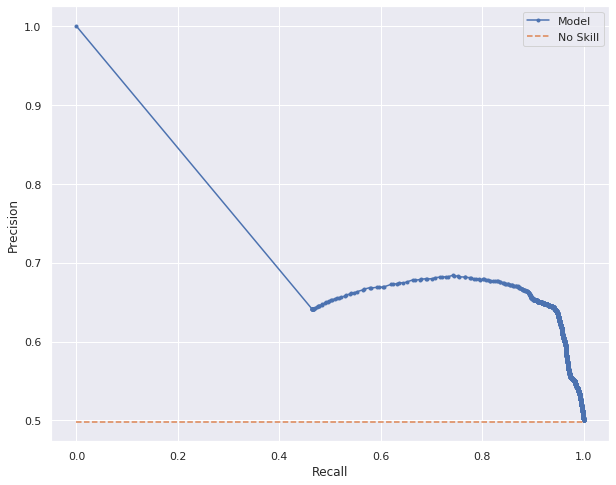


Cohen's kappa: 42.5% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



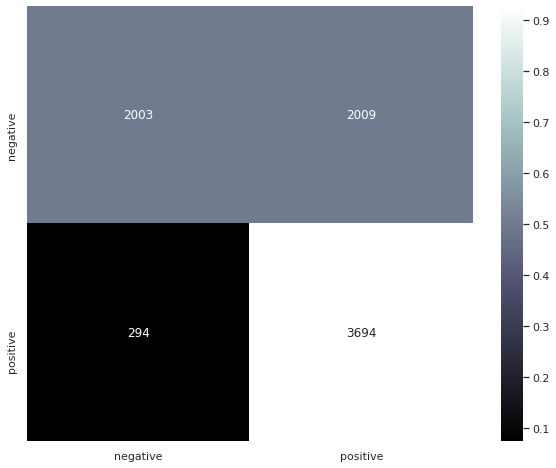

In [171]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>CNN – LSTM</h2>

In [128]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(100),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [129]:
if deep_learning:
    model = create_cnn_lstm_model(word_index, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         23278500  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         192128    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 23,562,329
Trainable params: 283,829
Non-trainable params: 23,278,500
____________________________________

2020-05-05 02:56:53 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3b70c620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5341WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b44087ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 02:59:23 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b44087ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 161s 201ms/step - loss: 0.6840 - accuracy: 0.5341 - val_loss: 0.6625 - val_accuracy: 0.7333
Epoch 2/50
800/800 [==============================] - 162s 203ms/step - loss: 0.6188 - accuracy: 0.7343 - val_loss: 0.5867 - val_accuracy: 0.8041
Epoch 3/50
800/800 [==============================] - 168s 210ms/step - loss: 0.5861 - accuracy: 0.8165 - val_loss: 0.5729 - val_accuracy: 0.8480
Epoch 4/50
800/800 [==============================] - 164s 205ms/step - loss: 0.5727 - accuracy: 0.8479 - val_loss: 0.5641 - val_accuracy: 0.8717
Epoch 5/50
800/800 [==============================] - 166s 207ms/step - loss: 0.5651 - accuracy: 0.8659 - val_loss: 0.559

In [130]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 18s 72ms/step - loss: 0.5391 - accuracy: 0.9266
[0.5390717387199402, 0.9266250133514404]


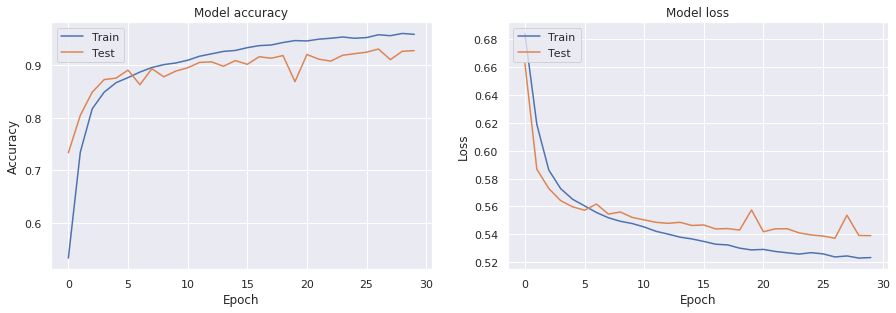

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 04:22:40 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b48dce488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93      4012
    positive       0.94      0.92      0.93      3988

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000


The balanced accuracy is : 92.66%


The Zero-one Loss is : 7.34%


Explained variance score: 0.707


ROC AUC=0.962 



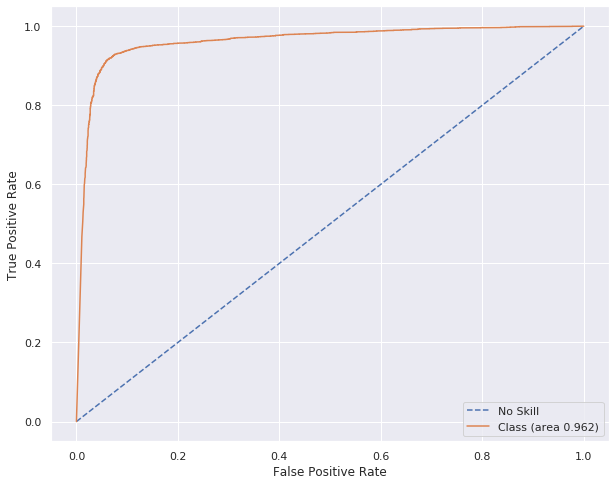



Model: f1-score=0.926 AUC=0.962




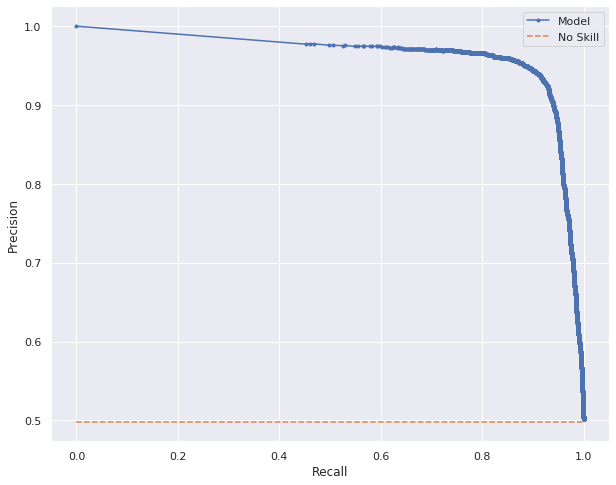


Cohen's kappa: 85.32% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



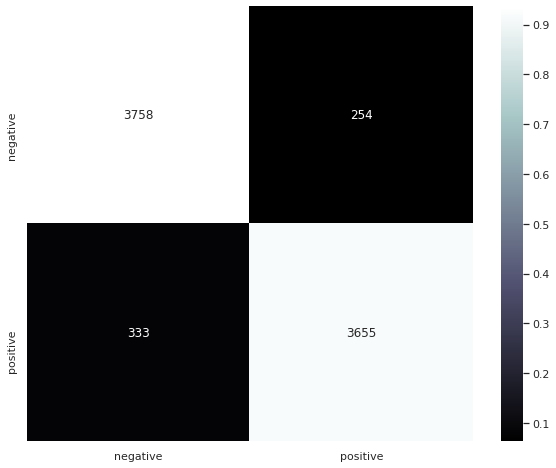

In [131]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>CNN – GRU</h2>

In [132]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(100, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(50),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [133]:
if deep_learning:
    model = create_cnn_gru_model(word_index, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         23278500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         300200    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
gru (GRU)                    (None, 50)                37800     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 23,616,551
Trainable params: 338,051
Non-trainable params: 23,278,500
____________________________________

2020-05-05 04:24:52 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3f07b598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.6493WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4886b6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 04:27:46 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4886b6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 187s 233ms/step - loss: 0.6460 - accuracy: 0.6493 - val_loss: 0.5988 - val_accuracy: 0.7648
Epoch 2/50
800/800 [==============================] - 185s 232ms/step - loss: 0.5795 - accuracy: 0.8323 - val_loss: 0.5674 - val_accuracy: 0.8539
Epoch 3/50
800/800 [==============================] - 187s 233ms/step - loss: 0.5664 - accuracy: 0.8620 - val_loss: 0.5629 - val_accuracy: 0.8730
Epoch 4/50
800/800 [==============================] - 193s 241ms/step - loss: 0.5598 - accuracy: 0.8773 - val_loss: 0.5608 - val_accuracy: 0.8856
Epoch 5/50
800/800 [==============================] - 186s 233ms/step - loss: 0.5537 - accuracy: 0.8909 - val_loss: 0.571

In [134]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 23s 90ms/step - loss: 0.5526 - accuracy: 0.8840
[0.5526250600814819, 0.8840000033378601]


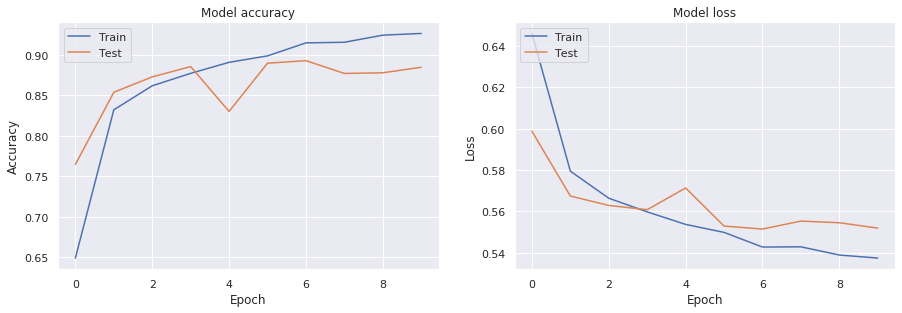

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 04:56:44 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b478f3378> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.83      0.96      0.89      4012
    positive       0.95      0.81      0.87      3988

    accuracy                           0.88      8000
   macro avg       0.89      0.88      0.88      8000
weighted avg       0.89      0.88      0.88      8000


The balanced accuracy is : 88.38%


The Zero-one Loss is : 11.6%


Explained variance score: 0.559


ROC AUC=0.957 



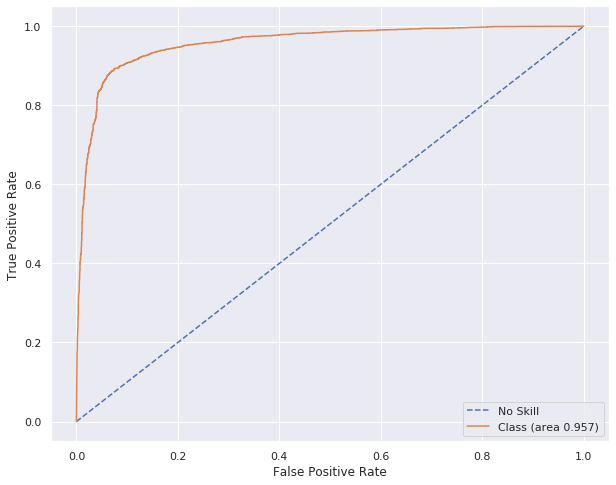



Model: f1-score=0.874 AUC=0.957




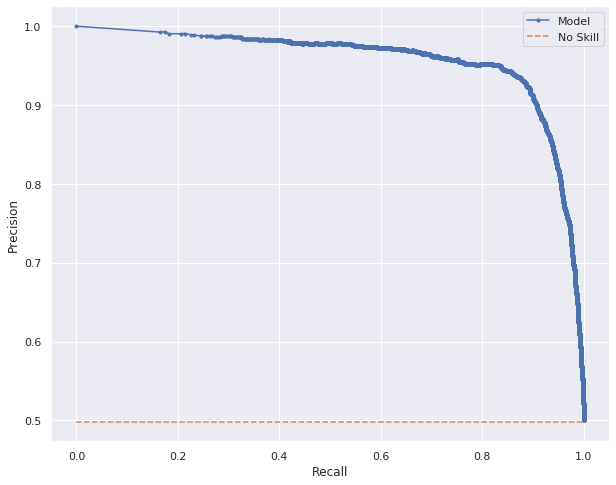


Cohen's kappa: 76.79% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



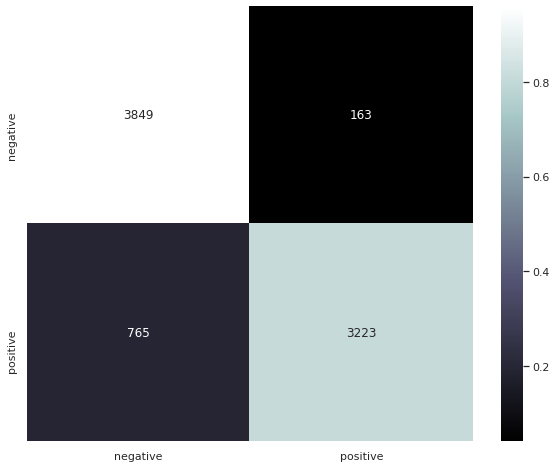

In [135]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Neural Network – GRU</h2>

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [136]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [137]:
if deep_learning:
    model = create_gru_model(word_index, pre_trained=False )


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         7759500   
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 7,782,351
Trainable params: 7,782,351
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence thi

2020-05-05 04:59:20 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b4a8910d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5012WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4a4d0598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 05:02:10 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4a4d0598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 175s 219ms/step - loss: 0.6940 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 186s 232ms/step - loss: 0.7560 - accuracy: 0.5136 - val_loss: 0.6935 - val_accuracy: 0.5025
Epoch 3/50
800/800 [==============================] - 179s 223ms/step - loss: 0.6191 - accuracy: 0.7306 - val_loss: 0.5585 - val_accuracy: 0.8813
Epoch 4/50
800/800 [==============================] - 182s 227ms/step - loss: 0.5369 - accuracy: 0.9314 - val_loss: 0.5499 - val_accuracy: 0.9130
Epoch 5/50
800/800 [==============================] - 178s 223ms/step - loss: 0.5227 - accuracy: 0.9606 - val_loss: 0.540

In [138]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 10s 40ms/step - loss: 0.5323 - accuracy: 0.9419
[0.5322637557983398, 0.9418749809265137]


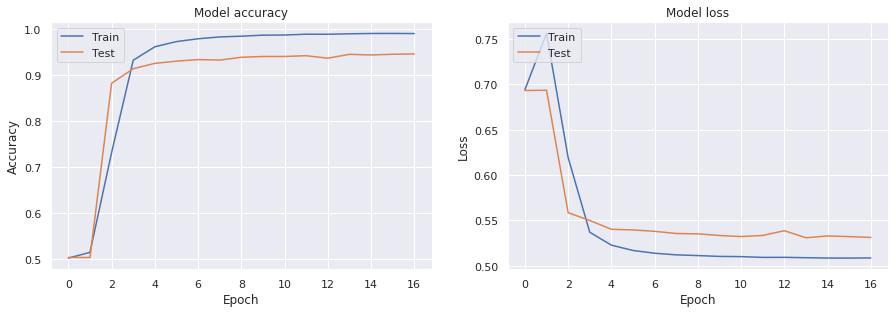

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 05:50:43 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b6d9972f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94      4012
    positive       0.95      0.94      0.94      3988

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000


The balanced accuracy is : 94.19%


The Zero-one Loss is : 5.81%


Explained variance score: 0.768


ROC AUC=0.979 



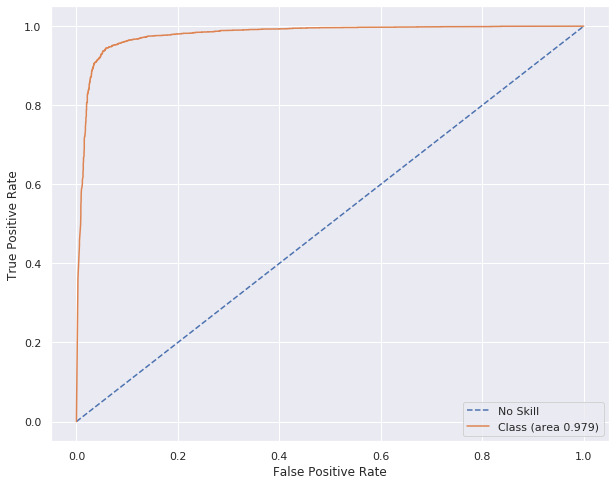



Model: f1-score=0.941 AUC=0.977




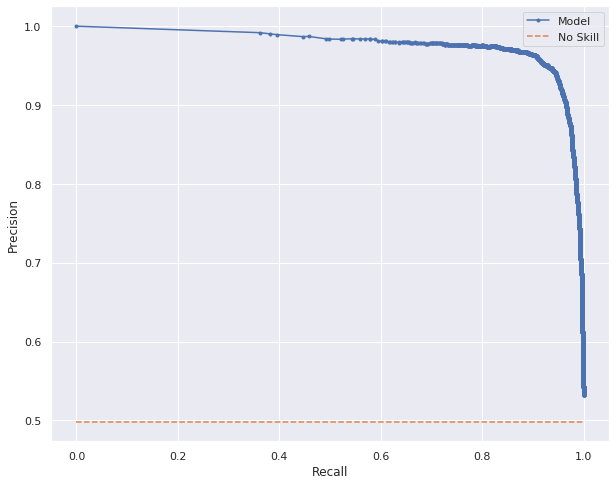


Cohen's kappa: 88.37% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



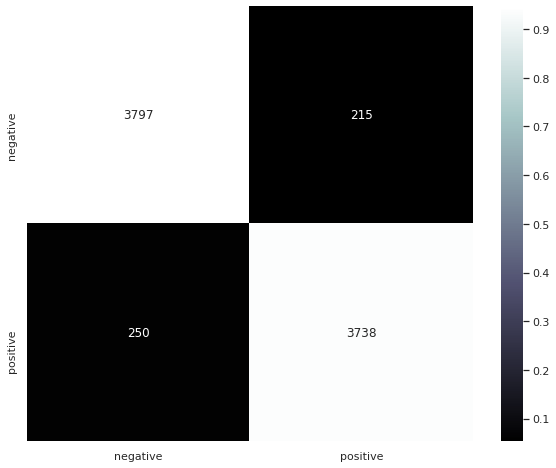

In [139]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Bidirectional RNN</h2>

In [140]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(50, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(50)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [141]:
if deep_learning:
    model = create_bidirec_rnn_model(word_index)
    
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         7759500   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         15100     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               15100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 7,789,801
Trainable params: 7,789,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Li

2020-05-05 05:51:57 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b46c7a1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6259WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4181d048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 05:56:10 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b4181d048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 262s 328ms/step - loss: 0.6584 - accuracy: 0.6259 - val_loss: 0.6348 - val_accuracy: 0.6708
Epoch 2/50
800/800 [==============================] - 258s 323ms/step - loss: 0.6333 - accuracy: 0.7237 - val_loss: 0.6597 - val_accuracy: 0.6328
Epoch 3/50
800/800 [==============================] - 263s 329ms/step - loss: 0.6255 - accuracy: 0.7280 - val_loss: 0.6553 - val_accuracy: 0.6902
Epoch 4/50
800/800 [==============================] - 267s 334ms/step - loss: 0.6588 - accuracy: 0.6445 - val_loss: 0.6893 - val_accuracy: 0.5180


In [142]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 14s 56ms/step - loss: 0.6853 - accuracy: 0.5249
[0.6853020191192627, 0.5248749852180481]


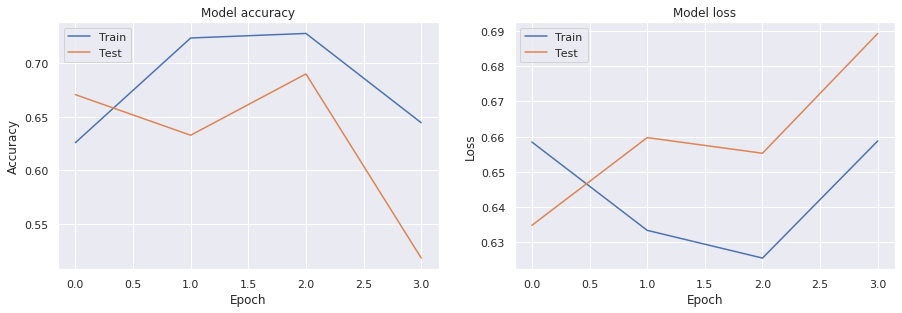

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 06:09:46 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b48002d08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.51      0.98      0.67      4012
    positive       0.77      0.07      0.12      3988

    accuracy                           0.52      8000
   macro avg       0.64      0.52      0.40      8000
weighted avg       0.64      0.52      0.40      8000


The balanced accuracy is : 52.35%


The Zero-one Loss is : 47.51%


Explained variance score: -0.074


ROC AUC=0.669 



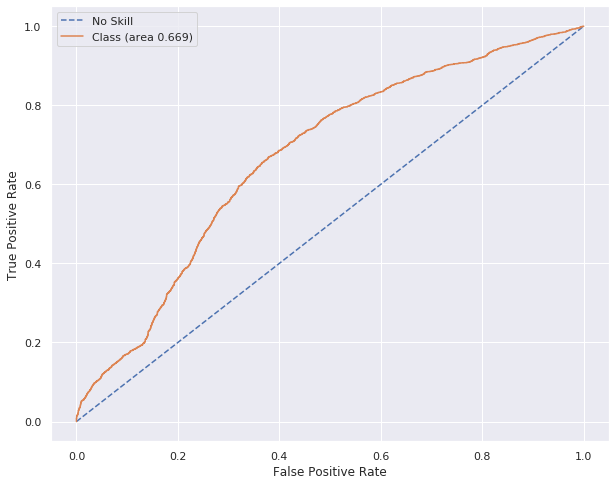



Model: f1-score=0.124 AUC=0.639




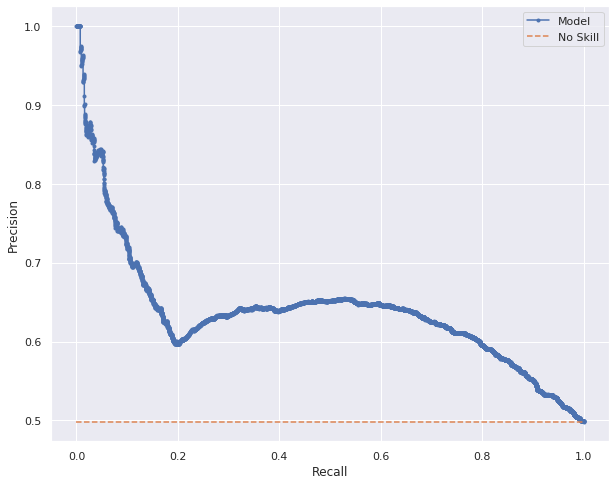


Cohen's kappa: 4.71% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



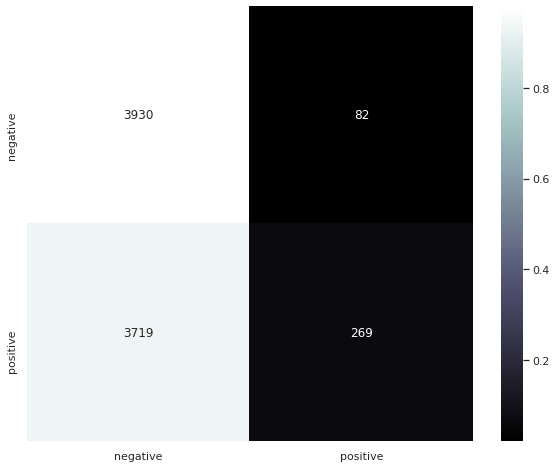

In [143]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Bidirectional LSTM</h2>

In [144]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [145]:
if deep_learning:
    model = create_bidirec_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         7759500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 7,920,501
Trainable params: 7,920,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence th

2020-05-05 06:11:36 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3e7d8ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5014WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b48a3a6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 06:17:32 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b48a3a6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 372s 465ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 444s 556ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/50
800/800 [==============================] - 343s 428ms/step - loss: 0.6912 - accuracy: 0.5254 - val_loss: 0.6738 - val_accuracy: 0.5897
Epoch 4/50
800/800 [==============================] - 415s 518ms/step - loss: 0.7798 - accuracy: 0.5365 - val_loss: 0.8158 - val_accuracy: 0.4975
Epoch 5/50
800/800 [==============================] - 348s 434ms/step - loss: 0.8146 - accuracy: 0.4987 - val_loss: 0.815

In [146]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 23s 93ms/step - loss: 0.8147 - accuracy: 0.4986
[0.8146790266036987, 0.4986250102519989]


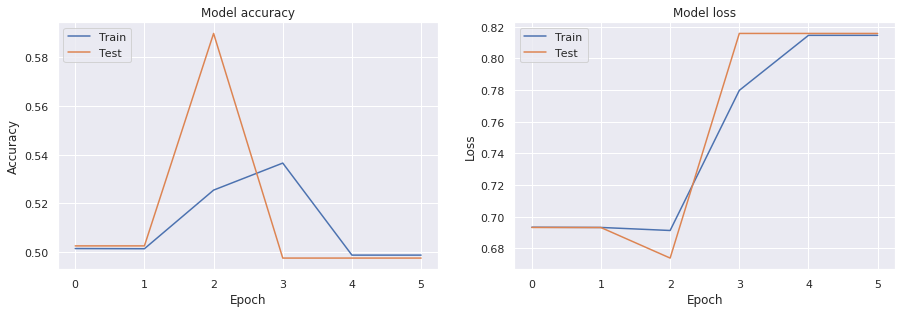

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 06:49:46 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b6ed61158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00      4012
    positive       0.50      1.00      0.67      3988

    accuracy                           0.50      8000
   macro avg       0.75      0.50      0.33      8000
weighted avg       0.75      0.50      0.33      8000


The balanced accuracy is : 50.01%


The Zero-one Loss is : 50.14%


Explained variance score: -0.0


ROC AUC=0.543 



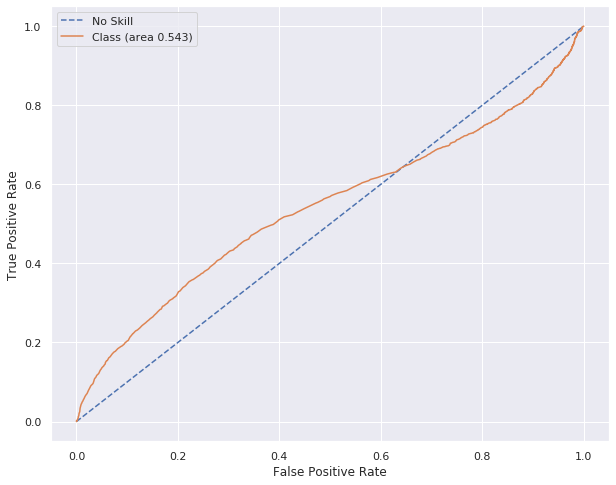



Model: f1-score=0.665 AUC=0.583




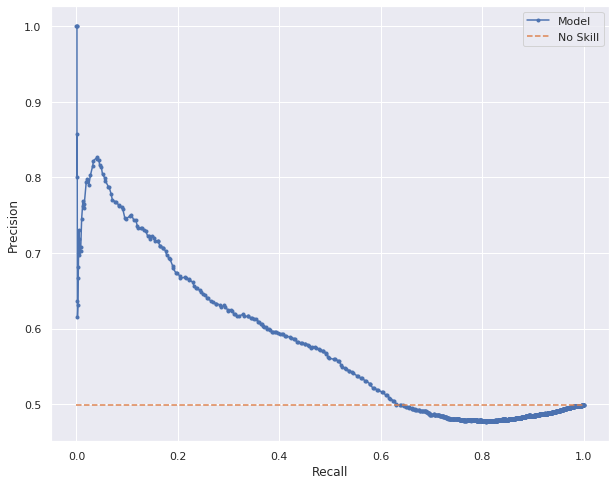


Cohen's kappa: 0.02% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



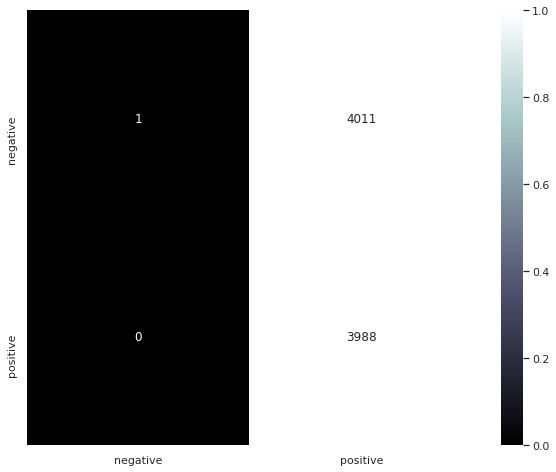

In [147]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Bidirectional GRU</h2>

In [148]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [149]:
if deep_learning:
    model = create_bidirec_gru_model(word_index, pre_trained=False)#, embedding_matrix=embedding_matrix, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         7759500   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               121200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 7,880,901
Trainable params: 7,880,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence th

2020-05-05 06:52:32 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b416f3158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5262WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b8dc02b70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 06:57:13 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b8dc02b70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 293s 366ms/step - loss: 0.6861 - accuracy: 0.5262 - val_loss: 0.6909 - val_accuracy: 0.5086
Epoch 2/50
800/800 [==============================] - 289s 361ms/step - loss: 0.6925 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 3/50
800/800 [==============================] - 296s 371ms/step - loss: 0.6929 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5030
Epoch 4/50
800/800 [==============================] - 340s 425ms/step - loss: 0.6618 - accuracy: 0.6023 - val_loss: 0.6069 - val_accuracy: 0.7381
Epoch 5/50
800/800 [==============================] - 292s 365ms/step - loss: 0.5673 - accuracy: 0.8592 - val_loss: 0.566

In [150]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 22s 88ms/step - loss: 0.5322 - accuracy: 0.9384
[0.5322183966636658, 0.9383749961853027]


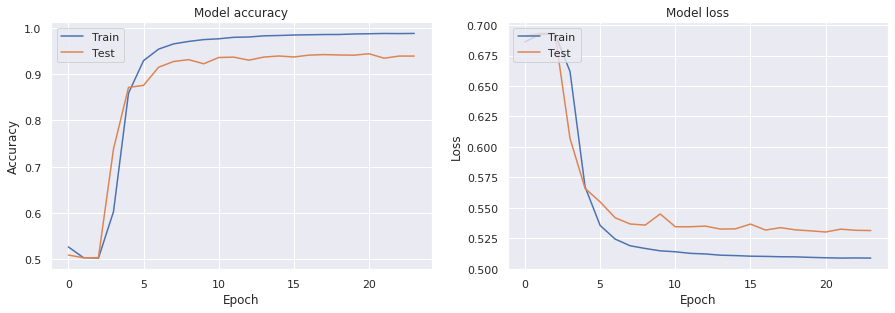

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 08:54:50 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b8ca9a2f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      4012
    positive       0.95      0.92      0.94      3988

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000


The balanced accuracy is : 93.83%


The Zero-one Loss is : 6.16%


Explained variance score: 0.755


ROC AUC=0.974 



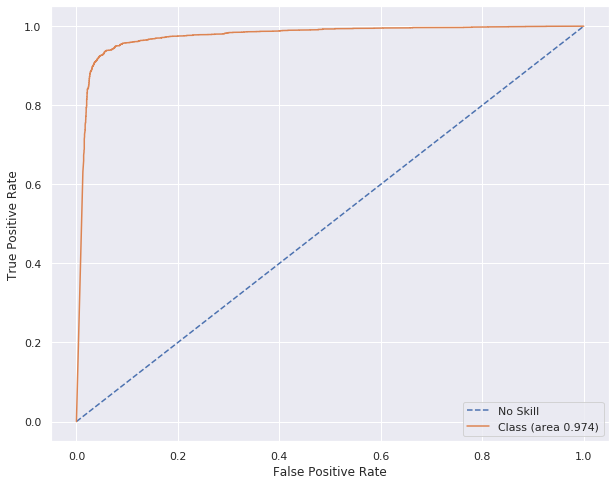



Model: f1-score=0.937 AUC=0.974




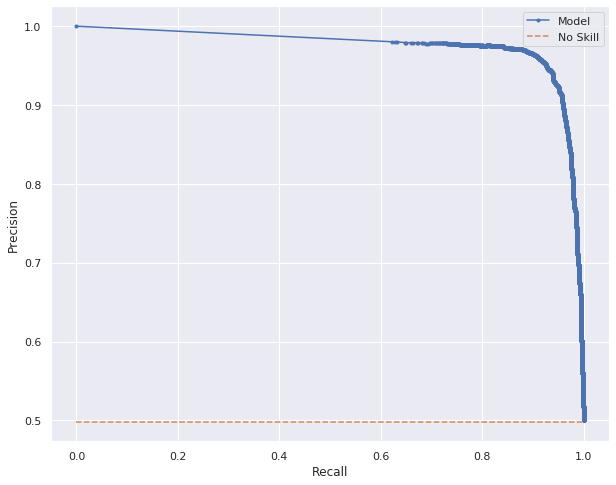


Cohen's kappa: 87.67% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



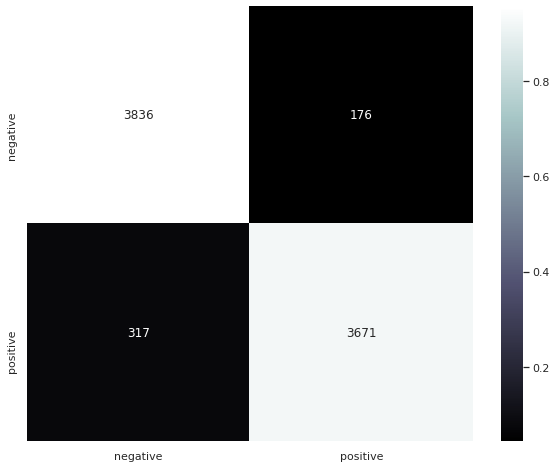

In [151]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Convolutional Neural Network</h2>

In [152]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [153]:
if deep_learning:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         7759500   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         121200    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)              

2020-05-05 08:57:20 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b46e5b400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5011WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b440876a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 09:04:21 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b440876a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 442s 553ms/step - loss: 0.6936 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 533s 666ms/step - loss: 0.6989 - accuracy: 0.5661 - val_loss: 0.8158 - val_accuracy: 0.4975
Epoch 3/50
800/800 [==============================] - 540s 675ms/step - loss: 0.6599 - accuracy: 0.6529 - val_loss: 0.6077 - val_accuracy: 0.7644
Epoch 4/50
800/800 [==============================] - 535s 669ms/step - loss: 0.6076 - accuracy: 0.7637 - val_loss: 0.6461 - val_accuracy: 0.6366
Epoch 5/50
800/800 [==============================] - 535s 669ms/step - loss: 0.6847 - accuracy: 0.5247 - val_loss: 0.693

In [154]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 39s 154ms/step - loss: 0.6931 - accuracy: 0.5015
[0.6931461095809937, 0.5015000104904175]


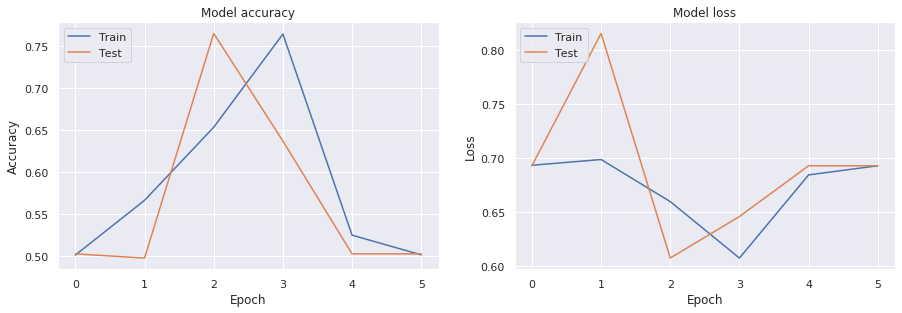

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 09:50:12 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b3f93a0d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/chris/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.50      1.00      0.67      4012
    positive       0.00      0.00      0.00      3988

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.34      8000


The balanced accuracy is : 50.0%


The Zero-one Loss is : 49.85%


Explained variance score: 0.0


ROC AUC=0.500 



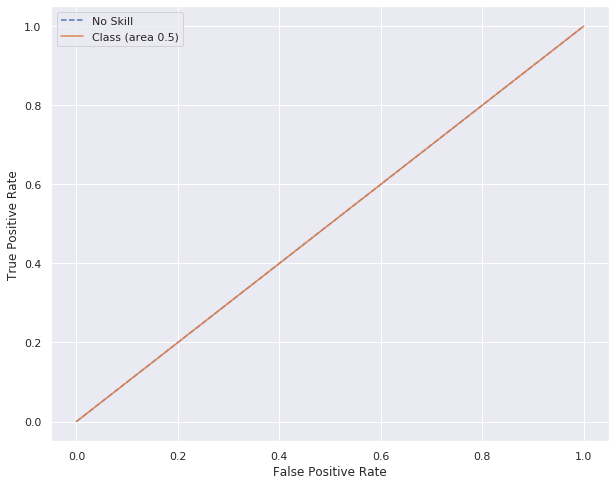



Model: f1-score=0.000 AUC=0.749




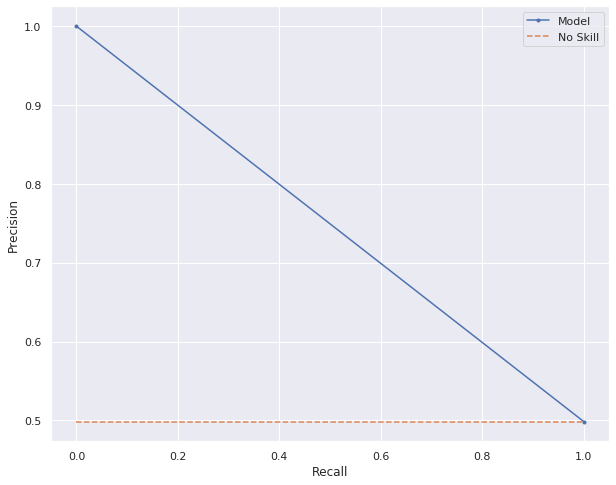


Cohen's kappa: 0.0% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



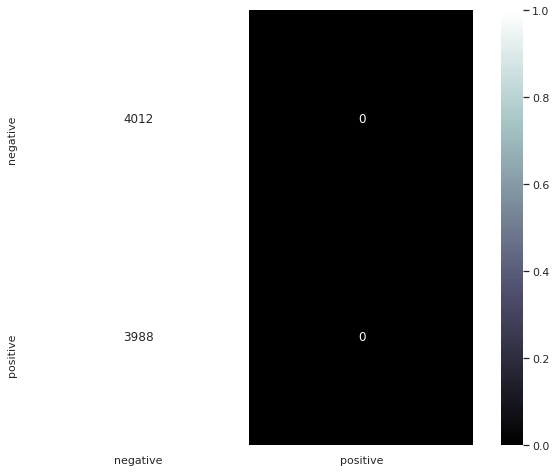

In [155]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Convolutional Neural Network variation 1</h2>

In [156]:
def create_rcnn_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [157]:
if deep_learning:
    model = create_rcnn_var1(word_index, pre_trained = True)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 300)         23278500  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 200)         320800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)              

2020-05-05 09:54:30 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b45850d08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5014WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b47123268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 10:04:14 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b47123268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 639s 799ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 614s 768ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/50
800/800 [==============================] - 499s 624ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/50
800/800 [==============================] - 535s 668ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025


In [158]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

250/250 [==============================] - 60s 238ms/step - loss: 0.6931 - accuracy: 0.5015
[0.6931461095809937, 0.5015000104904175]


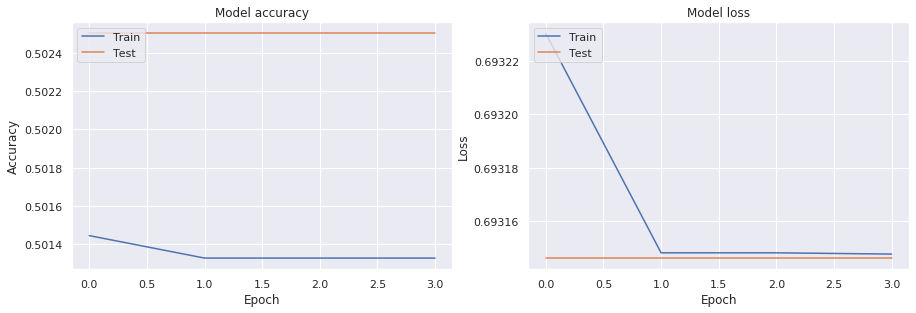

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 10:33:49 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f8b4a74b730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/chris/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.50      1.00      0.67      4012
    positive       0.00      0.00      0.00      3988

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.34      8000


The balanced accuracy is : 50.0%


The Zero-one Loss is : 49.85%


Explained variance score: 0.0


ROC AUC=0.587 



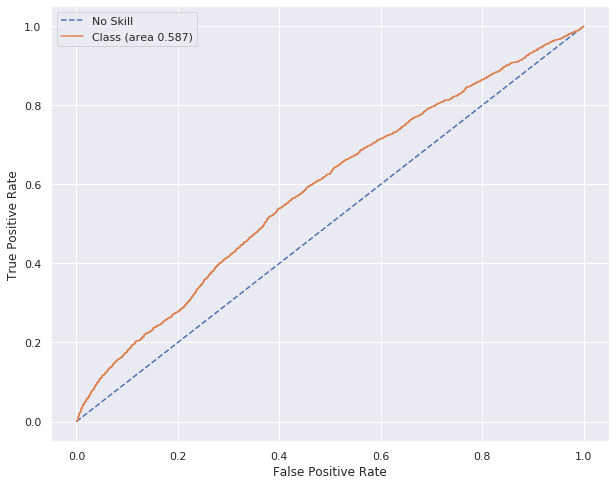



Model: f1-score=0.000 AUC=0.582




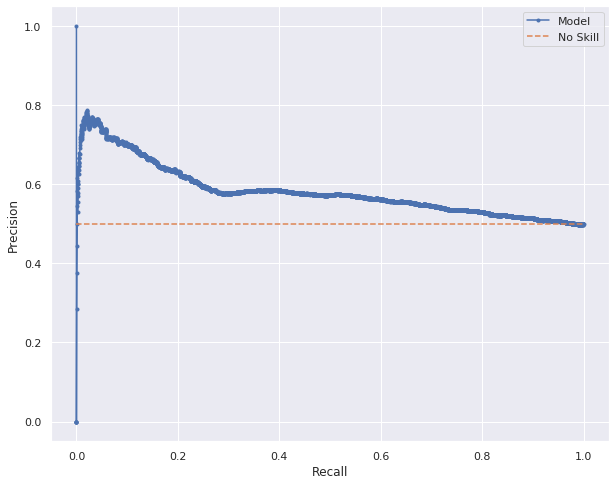


Cohen's kappa: 0.0% 

                 Predicted Negative  Predicted Positive
Actual Negative                3784                 228
Actual Positive                 197                3791

Confusion Matrix



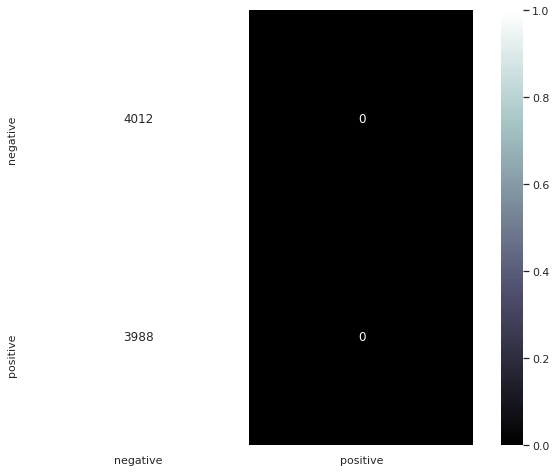

In [159]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Convulational Neural Network variation 2</h2>

In [160]:
def create_rcnn_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [161]:
if deep_learning:
    model = create_rcnn_var2(word_index,  pre_trained = False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         7759500   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 200)         121200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 200)         181200    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)              

2020-05-05 10:44:16 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b3c3cf7b8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5018WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6ce73158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 11:00:09 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b6ce73158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 1002s 1s/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 879s 1s/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/50
800/800 [==============================] - 818s 1s/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/50
228/800 [=======>......................] - ETA: 9:08 - loss: 0.6931 - accuracy: 0.5056

KeyboardInterrupt: 

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Recurrent Convulational Neural Network variation 3</h2>

In [164]:
def create_rcnn_var3(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(50,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(50,return_sequences=True)),
    keras.layers.Convolution1D(50, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [165]:
if deep_learning:
    model = create_rcnn_var3(word_index,  pre_trained = False)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 100)         7759500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 100)         45600     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 100)         60400     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 50)          15050     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 25)              

2020-05-05 11:40:10 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f8b42c5ee18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5008WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b45954c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-05 11:47:16 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b45954c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 444s 554ms/step - loss: 0.6939 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/50
800/800 [==============================] - 479s 599ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/50
800/800 [==============================] - 492s 615ms/step - loss: 0.6911 - accuracy: 0.5227 - val_loss: 0.6928 - val_accuracy: 0.5034
Epoch 4/50
800/800 [==============================] - 454s 567ms/step - loss: 0.6925 - accuracy: 0.5030 - val_loss: 0.6927 - val_accuracy: 0.5038
Epoch 5/50
800/800 [==============================] - 476s 595ms/step - loss: 0.6924 - accuracy: 0.5032 - val_loss: 0.692

KeyboardInterrupt: 

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Transformers</h2>

huggingface

In [ ]:
transformers_model=False

In [ ]:
import torch

In [ ]:
if transformers_model:
    camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [ ]:
from simpletransformers.classification import ClassificationModel

In [668]:
# Create a ClassificationModel
if transformers_model:
    model = ClassificationModel('camembert', 'camembert-base', use_cuda=False,  num_labels=3)

In [ ]:
self.args = {
    "output_dir": "outputs/",
    "cache_dir": "cache_dir/",

    "fp16": True,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,

    "logging_steps": 50,
    "save_steps": 2000,

    "overwrite_output_dir": False,
    "reprocess_input_data": False,
    "evaluate_during_training": False,

    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
}

In [ ]:
df.shape[0]*0.8

In [ ]:
# Create a TransformerModel with modified attributes
if transformers_model:
    model = TransformerModel('roberta', 'roberta-base', num_labels=4, args={'learning_rate':1e-5, 'num_train_epochs': 2, 'reprocess_input_data': True, 'overwrite_output_dir': True})


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.shape[0]*0.8 , df.shape[0]*0.2

In [ ]:
if transformers_model:
    encoder = preprocessing.LabelEncoder()
    #train_y = encoder.fit_transform(train_y)
    df.label = encoder.fit_transform(df.label)
    x_train = df[[TEXT, LABEL]].iloc[ :16496]
    x_test = df[[TEXT, LABEL]].iloc[16496:]

In [ ]:
if transformers_model:
    x_train.rename(columns={TEXT:"text"}, inplace=True)
    x_test.rename(columns={TEXT:"text"}, inplace=True)

In [ ]:
# Train the model
if transformers_model:
    model.train_model(x_train, reprocess_input_data=True)

In [ ]:
if transformers_model:
    result, model_outputs, wrong_predictions = model.eval_model(x_test)

In [ ]:
if transformers_model:
    print(result)

In [672]:
def func_precision_recall(result):
    
    tn, fp, fn, tp = result["tn"], result["fp"], result["fn"], result["tp"]
    
    print('''     Predicted       Predicted  
                 NO               YES
        Real   TN={}          FP={}
        NO     
        Real   FN={}           TP={}
        YES       '''.format(tn, fp, fn, tp))
    print('''
                  TP                     
    Precision = _______ = {}%    
                 TP+FP       


               TP
    Recall = ______  = {}%
              FN+TP           '''.format(round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)))
    return round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)


In [673]:
if transformers_model:
    func_precision_recall(result)

KeyError: 'tn'

<h3>Cohen’s kappa</h3>

In [ ]:
if transformers_model:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if transformers_model:
    func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if transformers_model:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if transformers_model:
    print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
if transformers_model:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if transformers_model:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Pre-Trained transformers models</h2>

bert / roberta / albert / camembert / ulmfit / gpt-2 

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Reinforcement Learning</h3>

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Autokeras</h3>

<h2>Knowledge Graphs</h2>